# Disappearing Forests - Milestone 2


## Introduction
In this notebook, we would try to answer these research questions using our data analysis skills. To do so, we set up some goals to achieve:
- Identify the trend of deforestation in the world
- Find the most deforested countries/areas
- Investigate the deforestation in the most forested countries
- Find the biggest producer of wood and investigate the impact of wood mining on deforestation
- Look for the biggest importer/exporter in the world and the connection among them
- Search for correlation between agriculture industry/animal husbandry and deforestation

## Index
0. **Data Preprocessing**

1. **The Deforestation Trend**
   
   1.1 Forests in each country
   
   1.2 Deforestation in each country
   
   1.3 Land distribution and explanation of changes in forest land share
   
2. **The Wood Trade**

   2.1 Wood production trend
   
   2.2 Wood Producers
   
   2.3 Trade flow

3. **Is agricultural industry influencing deforestation?**

   3.1 Plots of area distributions from satellite data
   
   3.2 Link between yield of agricultural land and deforestation
   
   3.3 PCA: clustering of the countries based on agricultural production share
   
   3.4 Graph: clustering of the countries based on agricultural production share
   
   3.5 Compare agriculture and forest land change in time
   
4. **Reforestation**

## **0. Data Preprocessing**
The initial preprocessing of the data was using __Shell__. The script used for preprocessing the normalized datasets from __FAOSTAT__ can be found in `data/faostat/clean_me.sh`. Here is the list of the datasets that we would work on (you can check for a **more detailed description in the appendix** at the end of the notebook).

- `Inputs_LandUse_E_All_Data_cleared.csv`
- `Environment_LandCover_E_All_Data_cleared.csv`
- `Environment_LandUse_E_All_Data_cleared.csv`
- `Environment_LivestockPatterns_E_All_Data_cleared.csv`
- `Forestry_E_All_Data_cleared.csv`
- `Forestry_Trade_Flows_E_All_Data_cleared.csv`
- `FAOSTAT_countries.csv`

In [1]:
# all the necessary imports
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook, export_png
from bokeh.models import Slider, HoverTool
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from IPython.core.display import display, HTML
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from bokeh.layouts import widgetbox, row, column
import geopandas as gpd
import json

warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
%matplotlib inline
sns.set()

In [2]:
# FAOSTAT are splitted into multiple groups
# FAOSTAT_countries consists of names of the countries
# FAOSTAT_country_groups consists of bigger regions, such as (Europe, Americas, East Europe etc.)
FAOSTAT_country_data = pd.read_csv("data/faostat/FAOSTAT_countries.csv", engine='python')
FAOSTAT_country_groups = FAOSTAT_country_data["Country Group"].unique()
FAOSTAT_countries = FAOSTAT_country_data["Country"].unique()
CONTINENTS = ['Africa', 'Asia', 'Oceania', 'Europe', 'Northern America', 'South America', 'Antarctic Region']
country_continent = np.concatenate((FAOSTAT_countries, CONTINENTS), axis=None)

## **1. The Deforestation Trend**
In this section, we explore in the data set `Inputs_LandUse_E_All_Data_cleared.csv` to find out related information about forestation and deforestation in each country. Ultimately, we would like to figure out the trend of deforestation over the certain time span.

### **1.1 Forests in each country**
In this part, we would dive into the dataset `Inputs_LandUse_E_All_Data_cleared.csv` to see forest situation in the nations around the globe, intending to compare the distribution among them.

In [3]:
# select forestation related features from Inputs_LandUse 
LAND_USE_FOREST_ITEMS = ['Forestry']

land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [4]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_unstack = forested_area_yearly.unstack("Year")

Here we present **top 5 countries ranked by forest land surface** (those having top 5 most important forestation matching to the record in [**Wiki**](https://en.wikipedia.org/wiki/List_of_countries_by_forest_area)). Specifically, we would take a look at their forest areas **from 1990 to 2017**.

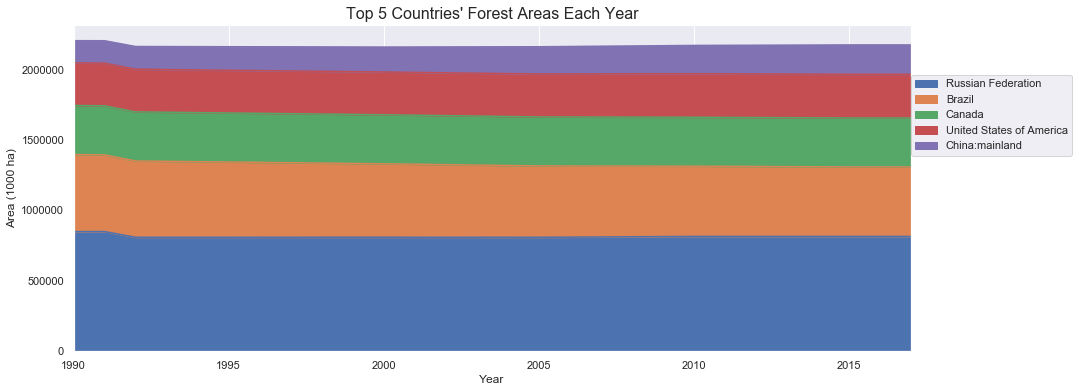

In [5]:
# plot the forest area of top 5 countries containing most important forestation 
forested_area_yearly_unstack.loc[['Russian Federation', 'Brazil', 'Canada', 'United States of America', 'China:mainland'], :]\
                            .T.plot.area(figsize = (15, 6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title("Top 5 Countries' Forest Areas Each Year", fontsize = 16)
plt.show()

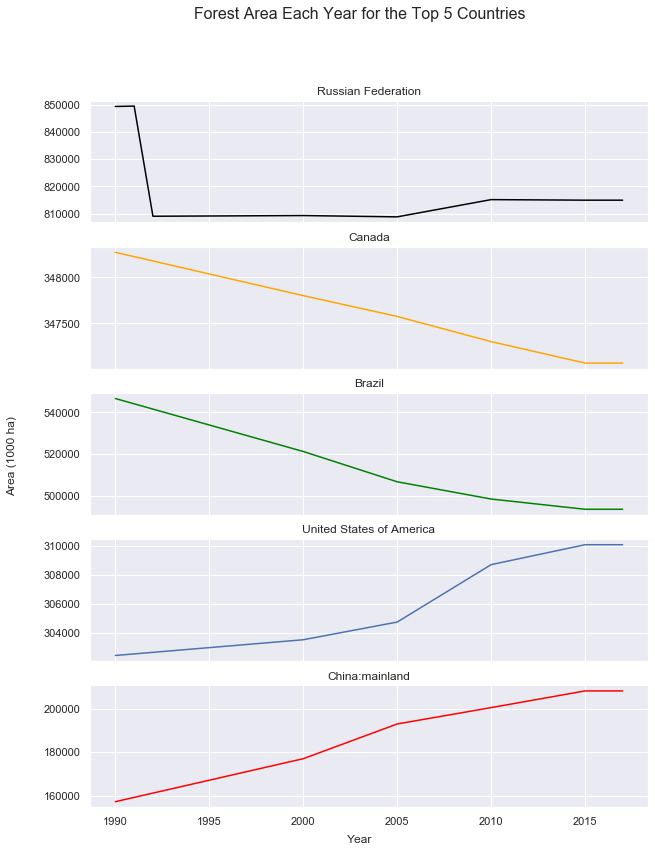

In [6]:
# look in more detailed for those top 5
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly.loc['Russian Federation'], color = 'black')
axes[1].plot(forested_area_yearly.loc['Canada'], color = 'orange')
axes[2].plot(forested_area_yearly.loc['Brazil'], color = 'green')
axes[3].plot(forested_area_yearly.loc['United States of America'])
axes[4].plot(forested_area_yearly.loc['China:mainland'], color = 'red')
axes[0].set_title('Russian Federation')
axes[1].set_title('Canada')
axes[2].set_title('Brazil')
axes[3].set_title('United States of America')
axes[4].set_title('China:mainland')
fig.suptitle("Forest Area Each Year for the Top 5 Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in the plot, both **Brazil and Canada have decreasing forest areas** in every coming year. Anyway, the **drop in percentage for Brazil is much bigger** than the one for Canada.
- On the contrary, **USA and China exhibit a postive trend** of increasing forest areas.
- As for **Russia**, we can see that there is a sudden drop from 1990, which may result from **dissolution of Soviet Union** and reduce the forest areas in Russia. Reference [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union).

To get insights from the broader view, we would create a **world map showing the forest percentage in every country**. Take the year in **2016** as an example.

In [7]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "Country"] = "China"
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "SDN"

# load 'Environment_LandUse_E_All_Data_cleared.csv' data set and filter columns
env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')
env_land_use = env_land_use_all[env_land_use_all.Item.isin(['Forest land']) & env_land_use_all.Element.str.match("Share in Land area")][["Area", "Year", "Value"]]

# join the codes to the countires
env_land_use = env_land_use.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
env_land_use_2016 = env_land_use[env_land_use['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(env_land_use_2016, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlGn'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 70)
# define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '40%', '45': '45%' , '50': '50%', '55': '55%', '60': '>60%'}

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('% Forrested area', '@Value')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)
# create figure object
p = figure(title = 'Share of forrest, 2016', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# save image
export_png(p, filename = 'data/images/share-of-forest-2016.png')
# display figure
show(p)

Loading BokehJS ...

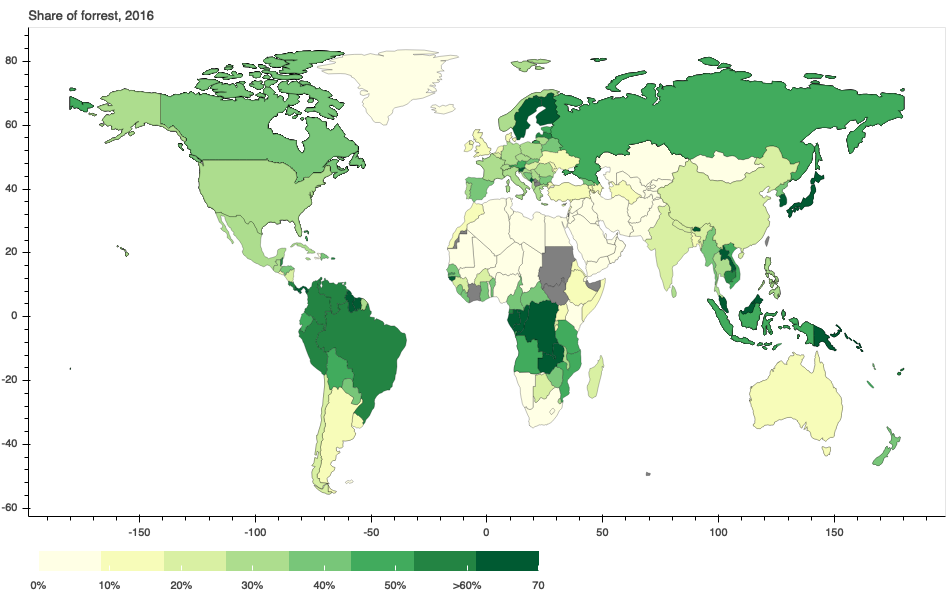

In [8]:
# since we used bokeh, which may not be seen in the notebook originally
# thus, we save the image so that readers could check it anyway
from IPython.display import Image
Image('data/images/share-of-forest-2016.png')

Next, we would like to check the forest areas **in each continent**.

In [9]:
# forest areas in continents over years
continents_forests_area = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &   
                                       land_use_all.Element.str.match('Area') & 
                                       land_use.Area.isin(CONTINENTS)].groupby(["Area", "Year"]).Value.sum()

continents_forests_area_unstack = continents_forests_area.unstack("Year")

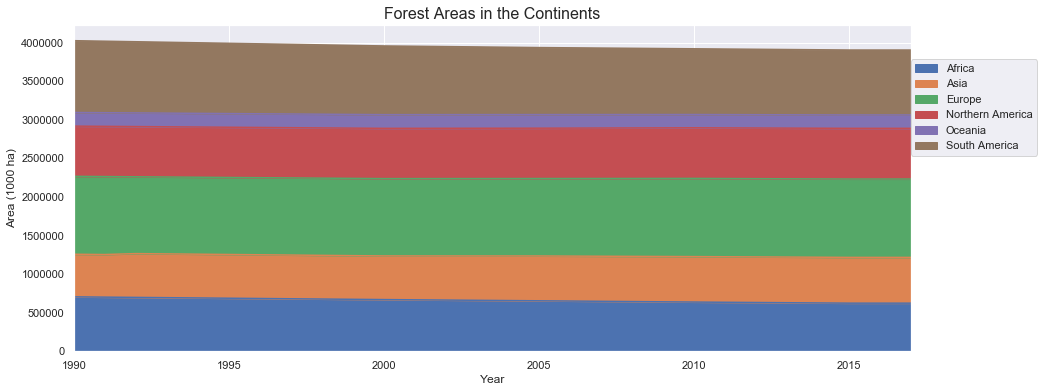

In [10]:
# plot forested areas in continents over the years
continetns_forests_plot = continents_forests_area_unstack.T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.ylabel('Area (1000 ha)')
plt.title('Forest Areas in the Continents', fontsize = 16)
plt.show()

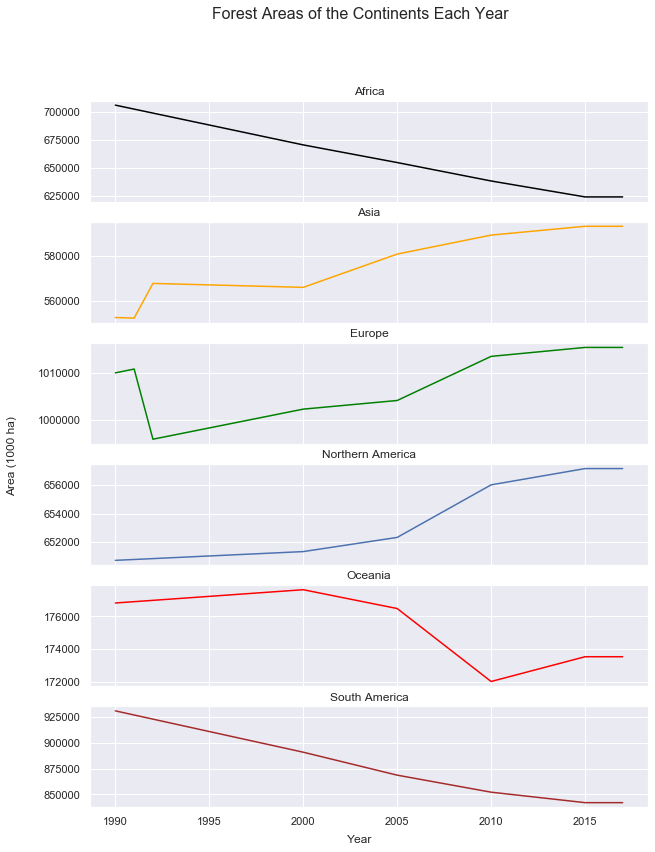

In [11]:
# look deeper for each continent
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 13))
axes[0].plot(continents_forests_area.loc['Africa'], color = 'black')
axes[1].plot(continents_forests_area.loc['Asia'], color = 'orange')
axes[2].plot(continents_forests_area.loc['Europe'], color = 'green')
axes[3].plot(continents_forests_area.loc['Northern America'])
axes[4].plot(continents_forests_area.loc['Oceania'], color = 'red')
axes[5].plot(continents_forests_area.loc['South America'], color = 'brown')
axes[0].set_title('Africa')
axes[1].set_title('Asia')
axes[2].set_title('Europe')
axes[3].set_title('Northern America')
axes[4].set_title('Oceania')
axes[5].set_title('South America')
fig.suptitle("Forest Areas of the Continents Each Year", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- From the plot, both **Africa and South America steadily reduced** their forest area over the years.
- Similarly but slightly bizarrely, we can see that the trend in **Oceania** went upward at first (until 2000) but then **dropped sharply** in 2005. We doubt that there may be some interesting factors causing this phenomenon.
- In contrast, the rest such as **Asia, Europe, and North America expanded** their forest areas.
- The most recent years (from 2015 on) exhibit completely flat trend: there could be a **problem in the dataset we'll need to fix**.

### **1.2 Deforestation in each country**
In this part, we focus on examining the **reduction of forests in every country** from 1990 to 2017. We compared the reduction between the first year and the last year, using again the dataset `Inputs_LandUse_E_All_Data_cleared.csv`.

In [12]:
# helpful functions to extract first and last non-null values
def first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
    
def last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

In [13]:
# top 5 countries which have deforestated most of forested areas over these years
forested_areas_diff = forested_area_yearly_unstack.apply(first, axis=1) - forested_area_yearly_unstack.apply(last, axis=1)
forested_areas_diff = forested_areas_diff.sort_values(ascending=False)
forested_areas_diff.head()

Area
Brazil                53167.0
Russian Federation    34493.9
Indonesia             27535.0
Nigeria               10241.0
Myanmar               10177.0
dtype: float64

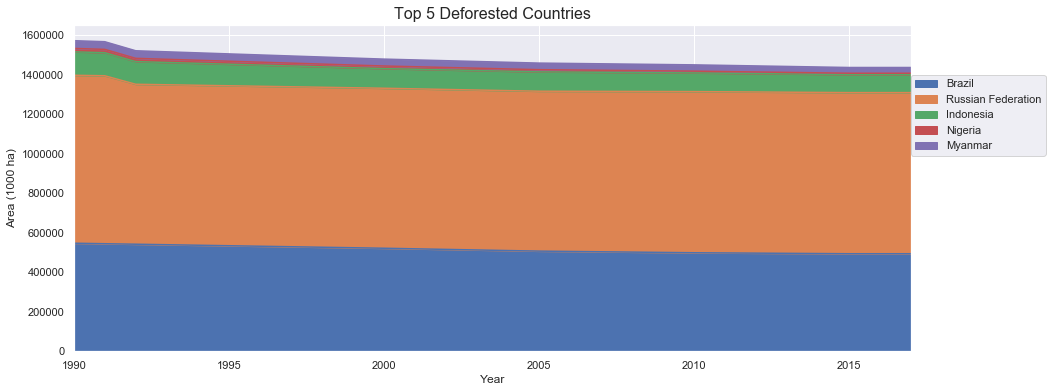

In [14]:
# top 5 countries which have deforestated most of forested areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

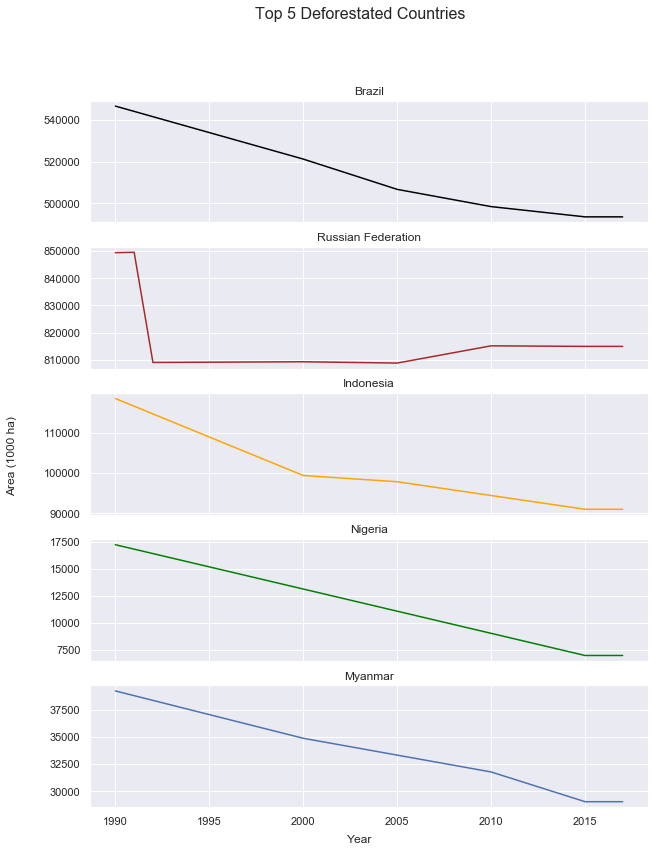

In [15]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Russian Federation'], color = 'brown')
axes[2].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[3].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[4].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[0].set_title('Brazil')
axes[1].set_title('Russian Federation')
axes[2].set_title('Indonesia')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("Top 5 Deforestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- We notice that the **rapid reduction in Russia** is mainly from 1991 to 1992. We speculate that the reason why Russia decreased much forests areas at that time is due to the **collapse of Soviet Union**, shrinking Russia's territory. We remove Russia to exclude the political issue. More details [**here**](https://en.wikipedia.org/wiki/Dissolution_of_the_Soviet_Union)

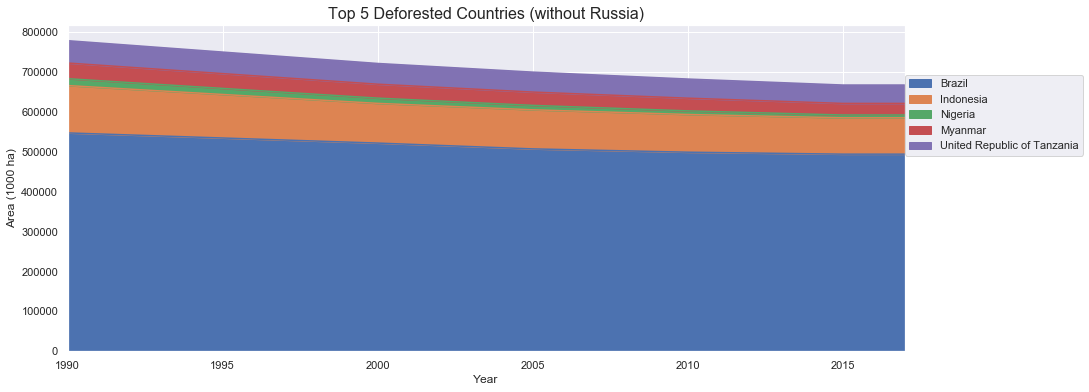

In [16]:
# top 5 countries which have deforestated most of forested areas over the years (without Russia)
forested_area_yearly_unstack.loc[forested_areas_diff[[0, 2, 3, 4, 5]].index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Deforested Countries (without Russia)', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

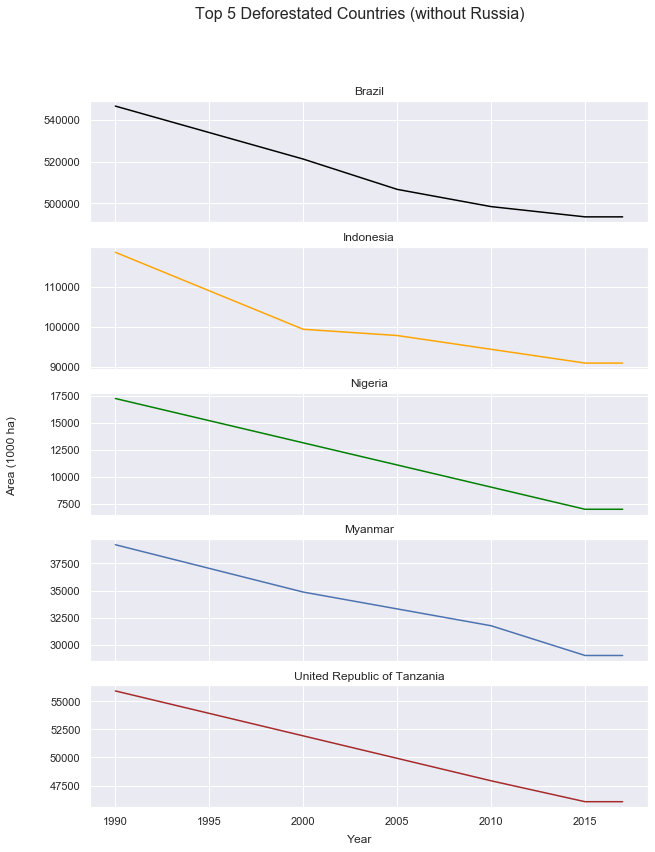

In [17]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['Brazil'], color = 'black')
axes[1].plot(forested_area_yearly_unstack.loc['Indonesia'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['Nigeria'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Myanmar'])
axes[4].plot(forested_area_yearly_unstack.loc['United Republic of Tanzania'], color = 'brown')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Nigeria')
axes[3].set_title('Myanmar')
axes[4].set_title('United Republic of Tanzania')
fig.suptitle("Top 5 Deforestated Countries (without Russia)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- As we can see in both plots, these top 5 deforested countries have been all **monotonically decreasing** their forest areas (with almost the same trend).
- At first, **Indonesia** had more rapid deforestation trend; however, after 2000, the **trend slowed down**.

In [18]:
# top 5 countries with biggest expansion of forests (Note: Russian Federation seems as an outlier)
forested_areas_diff.tail()

Area
Spain                       -4608.38
Viet Nam                    -5410.00
India                       -6743.00
United States of America    -7645.00
China:mainland             -51180.70
dtype: float64

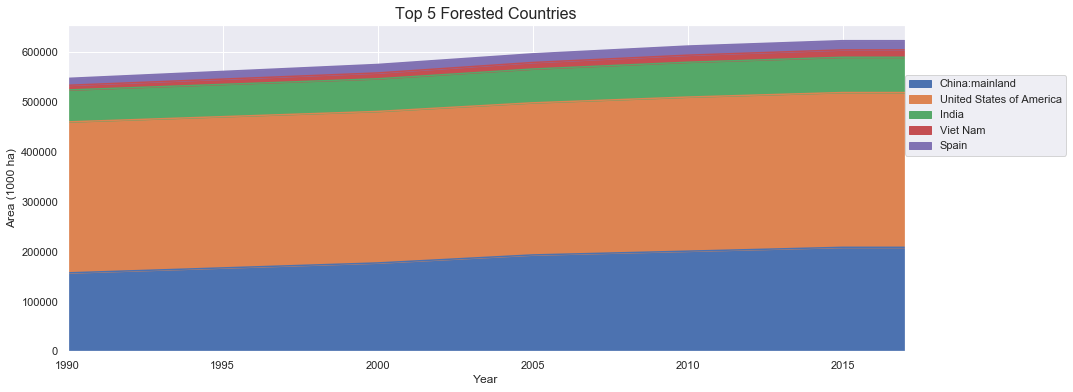

In [19]:
# top 5 countries which have forestated forest areas over the years
forested_area_yearly_unstack.loc[forested_areas_diff.sort_values(ascending= True).head().index]\
                    .T.plot.area(figsize=(15,6))
plt.legend(loc = (1, 0.6))
plt.title('Top 5 Forested Countries', fontsize = 16)
plt.ylabel('Area (1000 ha)')
plt.show()

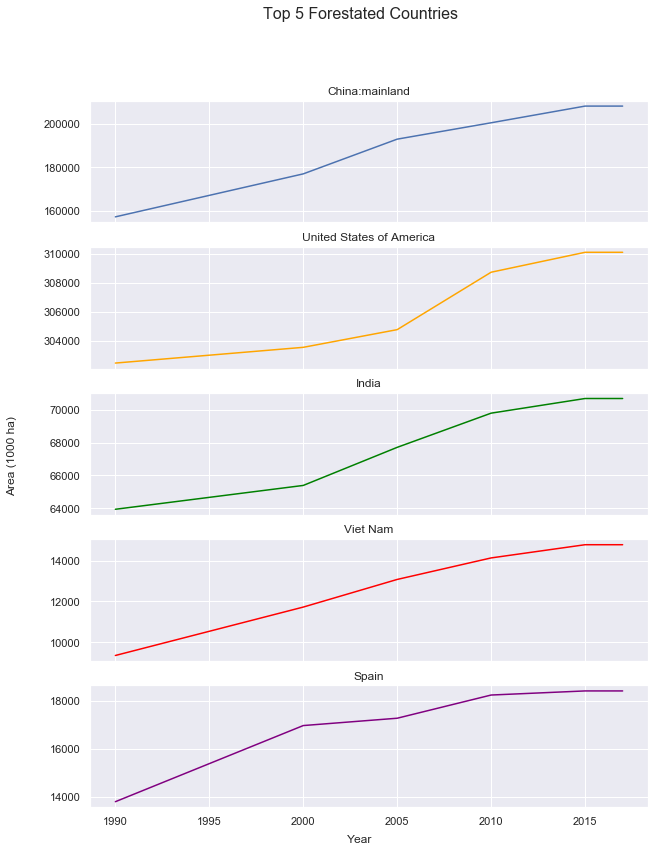

In [20]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))
axes[0].plot(forested_area_yearly_unstack.loc['China:mainland'])
axes[1].plot(forested_area_yearly_unstack.loc['United States of America'], color = 'orange')
axes[2].plot(forested_area_yearly_unstack.loc['India'], color = 'green')
axes[3].plot(forested_area_yearly_unstack.loc['Viet Nam'], color = 'red')
axes[4].plot(forested_area_yearly_unstack.loc['Spain'], color = 'purple')
axes[0].set_title('China:mainland')
axes[1].set_title('United States of America')
axes[2].set_title('India')
axes[3].set_title('Viet Nam')
axes[4].set_title('Spain')
fig.suptitle("Top 5 Forestated Countries", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
- Suprisingly, most top 5 countries with **fast-growing forest areas are developing countries** such as **China**, **India**, and **Vietnam**.

In [21]:
# plot the three kinds of forest (primary, regenerated and planted) for the selected country
LAND_USE_PARTIAL_FOREST_ITEMS = ['Primary Forest', 'Other naturally regenerated forest', 'Planted Forest']
land_use_detail = land_use_all[land_use_all.Item.isin(LAND_USE_PARTIAL_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area')]

In [22]:
# function helps us to plot three types of tree in the given country
def plot_three_types(country):
    country_partial_forested_area = land_use_detail.loc[(land_use_all['Item'].isin(LAND_USE_PARTIAL_FOREST_ITEMS)) &
                                                 (land_use_all['Area'] == country)]

    plt.figure(figsize=(9, 6))
    for forest_type in LAND_USE_PARTIAL_FOREST_ITEMS:
        plt.plot(country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Year'],
                 country_partial_forested_area.loc[country_partial_forested_area['Item'] == forest_type]['Value'])
    plt.title('Primary, regenerated and planted forests in ' + country + ' (1990-2017)')
    plt.legend(['Primary', 'Regenerated', 'Planted'], loc = (1, 0.6))
    plt.gca().set_xlabel('Year')
    plt.gca().set_ylabel('Forested area [1e7 m^2]')
    plt.show()

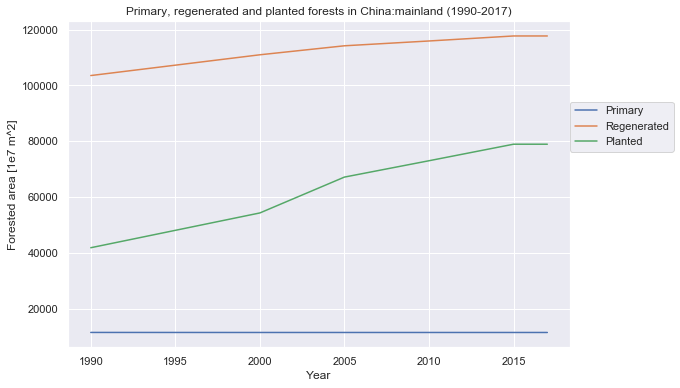

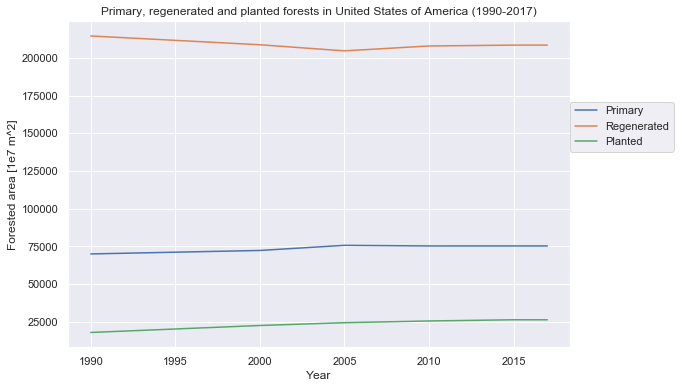

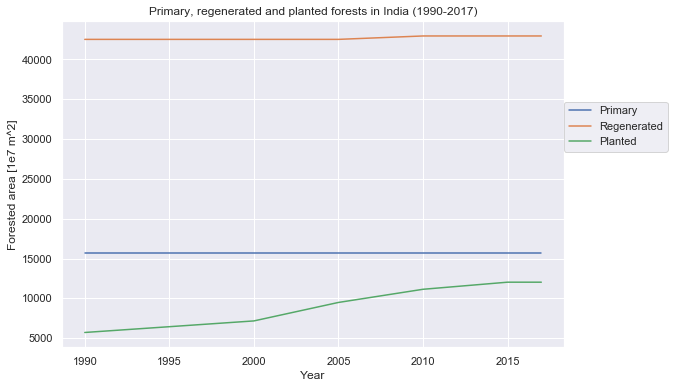

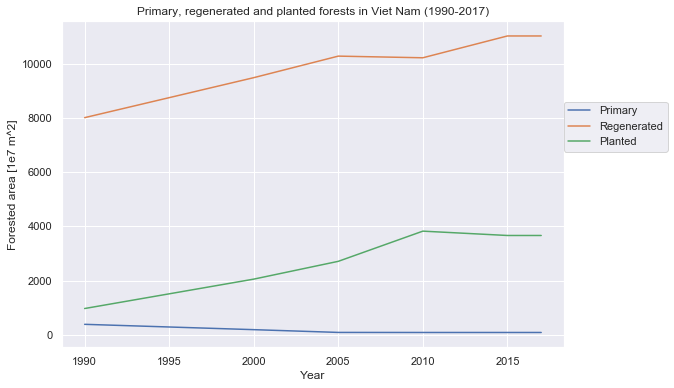

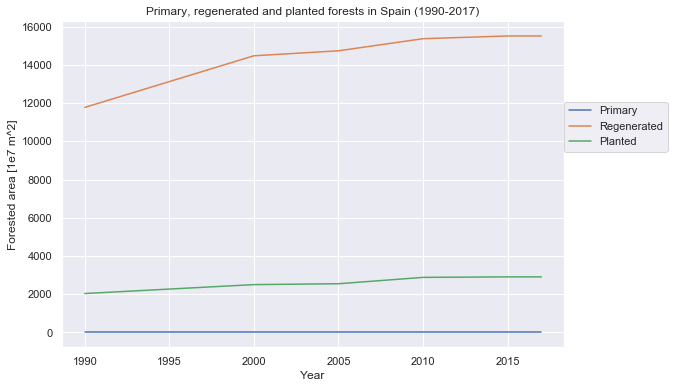

In [23]:
# plot three types of trees for the countries
plot_three_types('China:mainland')
plot_three_types('United States of America')
plot_three_types('India')
plot_three_types('Viet Nam')
plot_three_types('Spain')

> #### ***Explanation***
- From our investigation on these types of trees for each country, **China and India** could increase their forest area mainly because of **planted trees**.
- In **USA** overall forests are expanding even if the **regenerated ones are shrinking**.
- **Vietnam** and **Spain** rely on **both regenerated and planted** forests increase.

In this section, we research on the dataset `Environment_LandUse_E_All_Data_cleared.csv` to find out ***percentage*** of forestation and deforestation in each country. Still, we would like to figure out the trend of deforestation in percentage over the time span in each country.

In [24]:
# load ENV LansUse and select share of the forests in the each Area per yesr 
ENV_LAND_USE_FOREST = ['Forest land', 'Primary Forest', 'Planted Forest', 
                       'Other naturally regenerated forest']

env_land_use_all = pd.read_csv("data/faostat/Environment_LandUse_E_All_Data_cleared.csv", engine='python')

env_land_use = env_land_use_all[env_land_use_all.Item.isin(ENV_LAND_USE_FOREST) & env_land_use_all.Element.str.match("Share in Land area")]

env_land_use_yearly = env_land_use.groupby(["Area", "Year"]).Value.sum()
env_land_use_yearly = env_land_use_yearly.unstack("Year").fillna(method="backfill", axis=0)

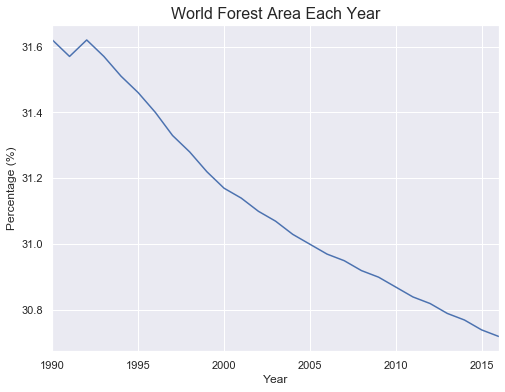

In [25]:
# plot the percentage of world forest areas 
env_land_use_yearly.loc['World'].plot(figsize = (8, 6))
plt.title('World Forest Area Each Year', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.show()

> #### ***Explanation***
- Sadly,  the world forest percentage is continuously decreasing, and it has dropped almost **1 percent since 1990**.
- More specifically, total deforestation area is equalivent to almost **30 times the territory of Switzerland**.

In [26]:
# compute the percentage of deforestation for each country
env_land_use_diff = env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, 0]\
                                        - env_land_use_yearly[env_land_use_yearly.index.isin(FAOSTAT_countries)].iloc[:, -1]

env_land_use_diff = env_land_use_diff.sort_values(ascending=False)

In [27]:
# top 5 countries which have deforestated by % of deforestated areas
env_land_use_diff.head()

Area
Pacific Islands Trust Territory    80.36
Serbia                             57.29
Azerbaijan                         37.35
Honduras                           32.74
USSR                               29.07
dtype: float64

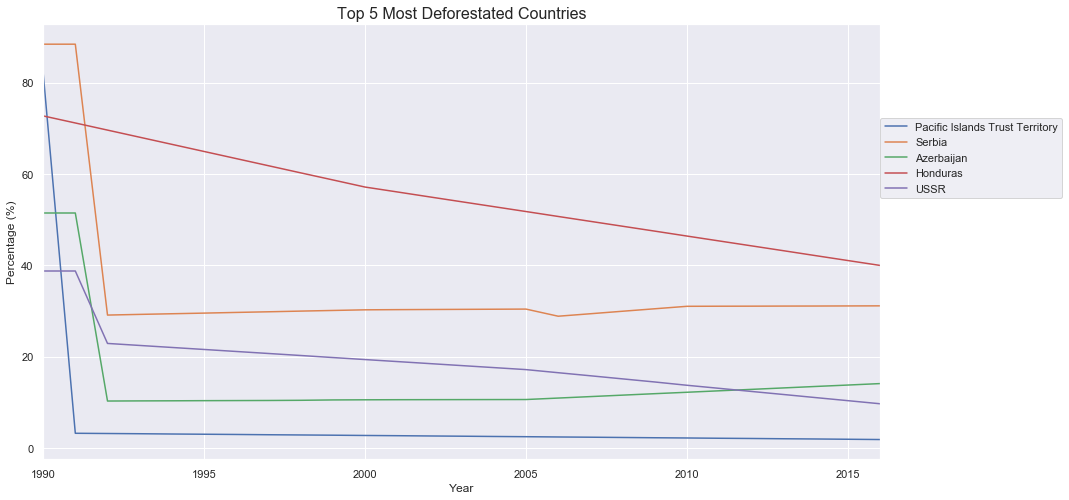

In [28]:
# plot the top 5 countries with most deforestation
env_land_use_yearly.loc[env_land_use_diff.head().index].T.plot(figsize=(15,8))
plt.title('Top 5 Most Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage (%)')
plt.legend(loc = (1, 0.6))
plt.show()

> #### ***Explanation***
- Top 5 countries except Honduras had decreased their forest percentage during early 1900s, and after that, these percentages remain stable to 2017. This can be, again, because of **dissolution of Soviet Union and Yugoslav**.

In [29]:
# show top 5 least deforested countries
env_land_use_diff.tail()

Area
Belgium-Luxembourg                 -36.43
Russian Federation                 -36.87
Micronesia (Federated States of)   -42.36
Netherlands Antilles (former)      -44.42
Sudan (former)                     -85.33
dtype: float64

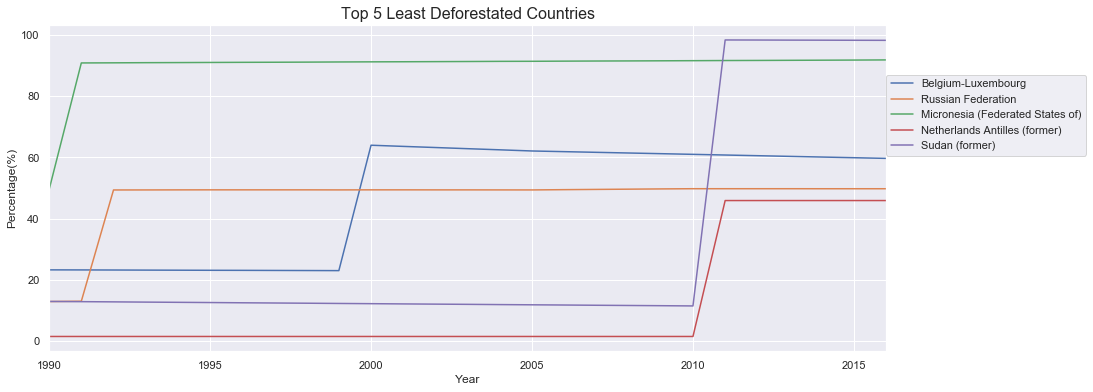

In [30]:
# plot the line graph to show the trend
env_land_use_yearly.loc[env_land_use_diff.tail().index].T.plot(figsize=(15,6))
plt.title('Top 5 Least Deforestated Countries', fontsize = 16)
plt.ylabel('Percentage(%)')
plt.legend(loc = (1, 0.6))
plt.show()

> #### ***Explanation***
- We could observe that instead of growing steadily, the trend of all top 5 deforestated countries have a sudden jump in different times, making their forest areas change rapidly within few years.
- **Belgium-Luxembourg** is an aggregation, **Sudan** and **Netherlands Antilles** have a 'former' tag, **Russian Federation** didn't exist as a whole after 1991.

### **1.3 Land distribution and explanation of changes in forest land share**
In this section we used the dataset `Environment_LandCover_E_All_Data_cleared.csv` which contains two types of measurements: CCI_LC and MODIS. The land distribution is inferred from satellite images and aggregated in different (not always perfectly consistent) ways. We want to analyse **changes in different land types with respect to the "ground level" in 1992** (for CCI_LC, or 2001 for MODIS).

In [31]:
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

In [32]:
# type of land use: comparison between different land types and deduction of 
# how the forested areas ('Tree-covered ares') transformed

def plot_land_type_differentials(country, data_type, land_types_number):
    """
    Plots the difference between the yearly surface change (increase or decrease) of different types of land,
    compared to a ground value (1992 for CCI_LC, 2001 for MODIS)
    :param str country:            should match with the 'Area' field
    :param str data_type:          CCI_LC or MODIS, come from different satellite images and different aggregation criteria
    :param int land_types_number:  number of categories plotted
    """
    
    # define the colors for each category (so that they are the same for every country plot)
    land_types_colors = ['royalblue',    # Artificial surfaces (including urban and associated areas)
                         'lime',         # Herbaceous crops
                         'red',          # Woody crops
                         'orange',       # Grassland
                         'green',        # Tree-covered areas
                         '.',            # Mangroves
                         'magenta',      # Shrub-covered areas
                         'darkgrey',     # Shrubs and/or herbaceous vegetation:aquatic or regularly flooded
                         'dodgerblue',   # Sparsely natural vegetated areas
                         'gold',         # Terrestrial barren land
                         '.',            # Permanent snow and glaciers
                         'aqua']         # Inland water bodies

    # create a DataFrame with year as only column. Years listed depend on the data_type
    country_land_types_yearly = pd.DataFrame(env_land_cover_all[env_land_cover_all.Element.str.match('Area from ' + data_type)].Year.unique(), 
                                             columns=['Year'])

    # fill the DataFrame columns: each column is a specific land type, each row is a year
    land_types = env_land_cover_all.Item.unique()
    for land_type in land_types:
        selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Item'] == land_type) &
                                                      (env_land_cover_all.Area.str.match(country)) &
                                                      (env_land_cover_all.Element.str.match('Area from ' + data_type)), 
                                                      'Value']
        if selected_item_yearly.isnull().sum() == 0: # if the selected land_type is registered every year
            country_land_types_yearly[land_type] = selected_item_yearly.values

    # compute differences w.r.t. first year of measurement for every column
    starting_year = country_land_types_yearly.iloc[0, 0]
    country_land_types_year_diff = country_land_types_yearly - country_land_types_yearly.iloc[0, :]
    country_land_types_year_diff['Year'] = country_land_types_year_diff['Year'] + starting_year    # restore correct year after subtraction

    # set 'Year' as the new index
    country_land_types_year_diff.set_index('Year', inplace=True)

    plt.figure(figsize=(12, 8))
    selected_land_types = []
    top_n_land_types = country_land_types_year_diff.iloc[-1, :].abs().sort_values(ascending=False).index[0:land_types_number]
    for column_index, land_type in enumerate(country_land_types_year_diff.columns):
        
        # skip land types that doesn't change so much (cleaner plot!)
        if land_type not in top_n_land_types:
            continue
            
        # save current column index to print column name in legend
        selected_land_types.append(column_index)

        plt.plot(country_land_types_year_diff.index,
                 country_land_types_year_diff[land_type],
                 color=land_types_colors[column_index])

    plt.hlines(0, starting_year, 2015, linestyles='dashed')
    plt.title(country + " land use differentials (" + data_type + " data)")
    plt.legend(country_land_types_year_diff.columns[selected_land_types], loc = (1, 0.6))
    plt.gca().set_xlabel('Year')
    plt.gca().set_ylabel('Differential surface w.r.t. ' + str(int(country_land_types_year_diff.index[0])) + ' value [1000 ha]')
    # plt.savefig(country + "_differentials_" + data_type)
    legend_offset = (plt.gca().get_ylim()[1] - plt.gca().get_ylim()[0]) / 100
    plt.annotate('Reference level (' + str(starting_year) + ')', [2010, legend_offset])
    plt.show()

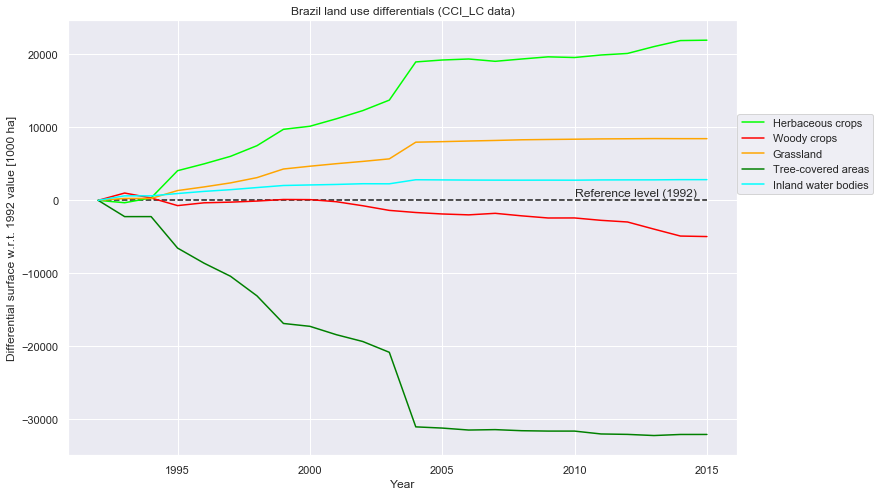

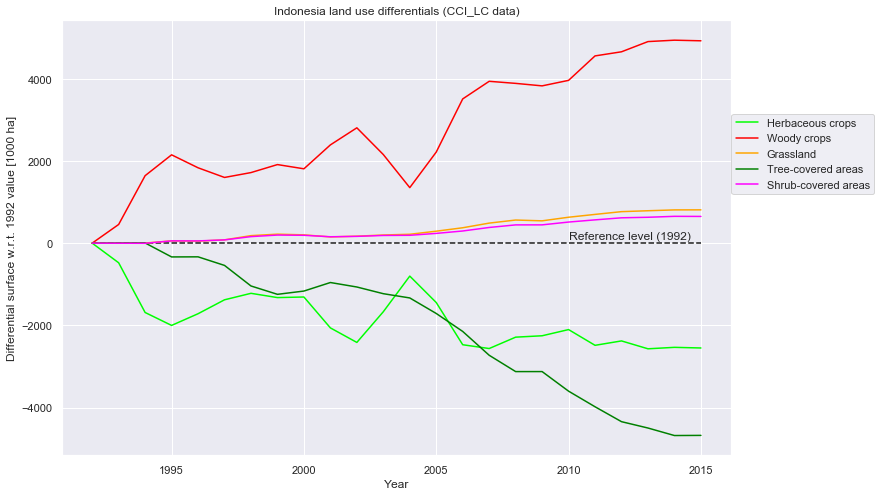

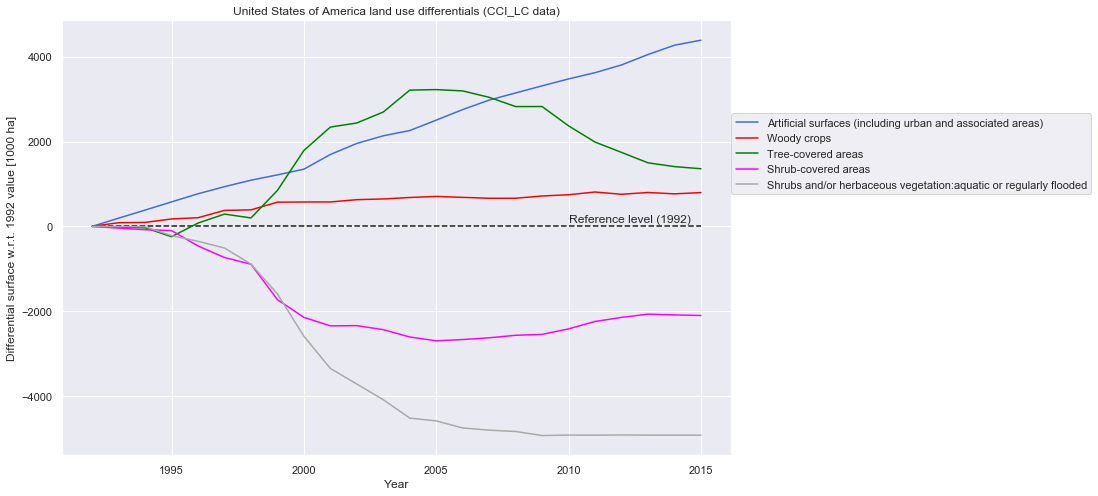

In [33]:
# Brazil
plot_land_type_differentials('Brazil', 'CCI_LC', 5)

# Indonesia
plot_land_type_differentials('Indonesia', 'CCI_LC', 5)

# United States of America
plot_land_type_differentials('United States of America', 'CCI_LC', 5)

> #### ***Explanation***

Here we represented plots for Brazil and Indonesia (which are among the biggest deforested countries) and USA (which, instead, increased the forest land).

+ **BRAZIL**: big decrease in tree-covered areas, compensated by creation of **new grasslands and fields of herbaceous crops** (Brazil agriculture is mostly based on **sugar cane**).
+ **INDONESIA**: in this case also herbaceous crops fields decrease to compensate the **increase of woody crops** (cultivated trees). This is linked to the main product of indonesian agriculture: **palm oil**.
+ **UNITED STATES OF AMERICA**: in this case tree-covered areas increased **subtracting land to shrubs** and other small vegetation lands.

## **2. The Wood Trade**
Now, based on `Forestry_E_All_Data_cleared.csv` and `Forestry_Trade_Flows_E_All_Data_cleared.csv`, we start to look for the **biggest producers and consumers of wood** in the world.

### 2.1 Wood production trend

In [34]:
# load Forestry data
forest_all = pd.read_csv("data/faostat/Forestry_E_All_Data_cleared.csv", engine='python')
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')

In [35]:
PRIMARY_FORREST_PRODUCTS = ['Roundwood', 'Sawnwood']

# the top 10 countries by deforested land area since 2010 (incl.)
DEC_FOREST = ['Brazil', 'Indonesia', 'Myanmar', 'Nigeria',
                  'United Republic of Tanzania', 'Paraguay', 'Zimbabwe',
                  'Democratic Republic of the Congo', 'Argentina',
                  'Bolivia (Plurinational State of)']

# the top 10 countries by forested land area since 2010 (incl.)
INC_FOREST = ['France', 'Viet Nam', 'India', "Lao People's Democratic Republic",
                'Gabon', 'Philippines', 'United States of America', 'Chile',
                'Australia', 'China:mainland']

In [36]:
# the wood production of countries in m3
wood_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.isin(FAOSTAT_countries) &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

# aggreaged production of wood since 2010
wp_agg = forest_all[(forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS)) & (forest_all.Year >= 2010) & (forest_all.Unit.str.match("m3")) & (forest_all.Element.str.match('Production')) & (forest_all.Area.isin(FAOSTAT_countries))]

In [37]:
# production of the wood in the world
world_production_m3 = forest_all[forest_all.Element.str.match("Production") & 
                                forest_all.Area.str.startswith("World") &
                                forest_all.Item.isin(PRIMARY_FORREST_PRODUCTS) &
                                forest_all.Unit.str.match("m3")]\
                                .groupby(["Area", "Year"])\
                                .Value.sum().unstack("Year")

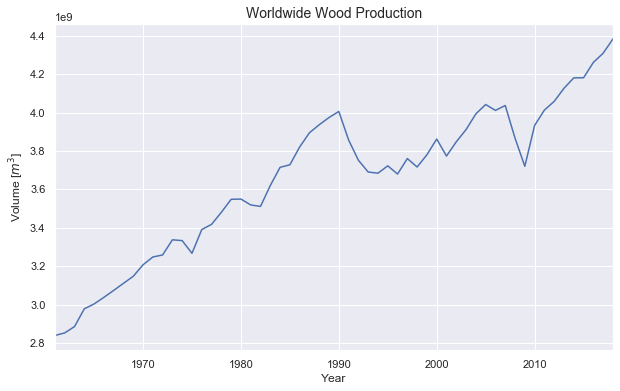

In [38]:
# the wood production in the world
plt.figure(figsize = (10, 6))
world_production_m3.loc["World"].plot()
plt.title('Worldwide Wood Production', size = 14)
plt.ylabel("Volume [$m^3$]")
plt.show()

> #### ***Explanation***
Even though the decrease of the forest in the world seems to be constant, the production of the wood is increasing almost every year. The production has been increased by 15 percents in the last 10 years. This trend does not seem to be sustainable.

Show the trend in more details for each specific wood type.

In [39]:
PRIMARY_FOREST_PRODUCTS = ['Roundwood', 'Sawnwood', 'Wood-based panels', 'Paper and paperboard',
                           'Pulpwood:round and split:all species (production)']

# extract world production of primary forest products
world_production = forest_all[forest_all.Element.str.match("Production") & 
                              forest_all.Area.isin(["World"]) &
                              forest_all.Item.isin(PRIMARY_FOREST_PRODUCTS)]

# # select all years from 1995 to 2015 (both included)
# world_production = world_production[(world_production.Year >= 1995) & (world_production.Year <= 2015)]

# sum by Item per year
world_production = world_production.groupby(["Item", "Year"]).Value.sum().reset_index()

# conver 'Paper and paperboard' from tonnes to m3
paper_products_mask = world_production.Item.isin(['Paper and paperboard'])
world_production.loc[paper_products_mask, "Value"] = world_production.loc[paper_products_mask].Value.values * 1.2

# normalize the values to show only changes in production of each Item
for prod in PRIMARY_FOREST_PRODUCTS:
    start_year = world_production[world_production.Item.isin([prod])].Year.min()
    start_prod = world_production[(world_production.Item.isin([prod])) & 
                                  (world_production.Year == start_year)].Value.values[0]
    world_production.loc[world_production.Item.isin([prod]), "Value"] = world_production[world_production.Item.isin([prod])].Value.values - start_prod


In [40]:
fig = go.Figure()
fig.add_trace(go.Scatter(
                    x=world_production[world_production.Item.isin(['Roundwood'])].Year.values, 
                    y=world_production[world_production.Item.isin(['Roundwood'])].Value.values,
                    mode='lines+markers',
                    name='Roundwood'))
fig.add_trace(go.Scatter(
                    x=world_production[world_production.Item.isin(['Sawnwood'])].Year.values, 
                    y=world_production[world_production.Item.isin(['Sawnwood'])].Value.values,
                    mode='lines+markers',
                    name='Sawnwood'))
fig.add_trace(go.Scatter(
                    x=world_production[world_production.Item.isin(['Wood-based panels'])].Year.values, 
                    y=world_production[world_production.Item.isin(['Wood-based panels'])].Value.values,
                    mode='lines+markers',
                    name='Wood-based panels'))
fig.add_trace(go.Scatter(
                    x=world_production[world_production.Item.isin(['Paper and paperboard'])].Year.values, 
                    y=world_production[world_production.Item.isin(['Paper and paperboard'])].Value.values,
                    mode='lines+markers',
                    name='Paper and paperboard'))
fig.add_trace(go.Scatter(
                    x=world_production[world_production.Item.isin(['Pulpwood:round and split:all species (production)'])].Year.values, 
                    y=world_production[world_production.Item.isin(['Pulpwood:round and split:all species (production)'])].Value.values,
                    mode='lines+markers',
                    name='Pulpwood'))

fig.update_layout(
    yaxis_title="$Change in Production [m^3]$",
    autosize=False,
    width=700,
    height=600,
)
fig.show()

> #### ***Explanation***
Wood products are integral part of our daily lives. We have been usig this material from beginning of our kind, but the demand has never been this big. The production of primary wood products has increased by 20 percents in the past few decades. And this trend doesn't seem to stop. The forests  Co2 on our planet and with every sawn tree this number decreases. The production of wood-based panel has increased by alarming 160 percent from 1995. The growth is steady, only singifacant influence which was able the affect the wood production in the world was the econominc crisis in 2007-2009.

Next, we would like to find the relation between wood production and forest areas. We focus on years from 1995 to 2015.

In [41]:
# filter continets and primary forest products
continent_production = forest_all[forest_all.Element.str.match("Production") & 
                                    forest_all.Area.isin(CONTINENTS) &
                                    forest_all.Item.isin(PRIMARY_FOREST_PRODUCTS)]

# filter are of each continent
land_use = land_use_all[land_use_all.Item.isin(LAND_USE_FOREST_ITEMS) &
                        land_use_all.Element.str.match('Area') &
                        land_use_all.Area.isin(CONTINENTS)]

# find best suitable min and max years in both datasets 
year_min = int(max(max(continent_production.Year.min(), land_use.Year.min()), 1995))
year_max = int(min(min(continent_production.Year.max(), land_use.Year.max()), 2015))

In [42]:
fig = go.Figure()

fig = make_subplots(
    rows=1, 
    cols=2,
    subplot_titles=("Production (m3)", "Forested area (1000 ha)"),
    shared_yaxes=True
)

for year in range(year_min, year_max +1):
    items = continent_production[continent_production.Year == year].groupby(["Area", "Item"]).Value.sum()
    items = items.reset_index()

    # sort continets in order which will be used in plot
    items = items[items.Area.str.match("Oceania")].append(items[items.Area.str.match("South America")])\
                                                  .append(items[items.Area.str.match("Africa")])\
                                                  .append(items[items.Area.str.match("Northern America")])\
                                                  .append(items[items.Area.str.match("Europe")])\
                                                  .append(items[items.Area.str.match("Asia")])
    fig.add_trace(
        go.Bar(
            y=items[items.Item.str.match("Roundwood")].Area.values,
            x=items[items.Item.str.match("Roundwood")].Value.values,
            name='Roundwood, ' + str(year),
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=1, 
    )
    
    fig.add_trace(
        go.Bar(
            y=items[items.Item.str.match("Wood-based panels")].Area.values,
            x=items[items.Item.str.match("Wood-based panels")].Value.values,
            name='Wood-based panels, ' + str(year),
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Bar(
            y=items[items.Item.str.match("Sawnwood")].Area.values,
            x=items[items.Item.str.match("Sawnwood")].Value.values,
            name='Sawnwood, ' + str(year),
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Bar(
            y=items[items.Item.isin(["Pulpwood:round and split:all species (production)"])].Area.values,
            x=items[items.Item.isin(["Pulpwood:round and split:all species (production)"])].Value.values,
            name='Pulpwood, ' + str(year),
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=1,
    )

    fig.add_trace(
        go.Bar(
            y=items[items.Item.str.match('Paper and paperboard')].Area.values,
            x=items[items.Item.str.match('Paper and paperboard')].Value.values * 1.2,
            name='Paper and paperboard, ' + str(year),
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=1,
    )

    land = land_use[land_use.Year == year].groupby(["Area", "Item"]).Value.sum()
    land = land.reset_index()
    land = land[land.Area.str.match("Oceania")].append(land[land.Area.str.match("South America")])\
                                               .append(land[land.Area.str.match("Africa")])\
                                               .append(land[land.Area.str.match("Northern America")])\
                                               .append(land[land.Area.str.match("Europe")])\
                                               .append(land[land.Area.str.match("Asia")])
    fig.add_trace(
        go.Bar(
            y=land.Area.values,
            x=land.Value.values,
            name='Forested area, ' + str(year),
            orientation='h',
            visible=False,
        ),
        row=1,
        col=2,
    )

In [43]:
# plot the graph
for i in range(6):
    fig.data[i].visible = True

steps = []
for i in range(int(len(fig.data)/6)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
        label='{}'.format(i + year_min),
    )
    for j in range(6):
        step["args"][1][i*6 + j] = True
    steps.append(step)

sliders = [dict(
    active=1991,
    currentvalue={"prefix": "Year: "},
    steps=steps
)]
fig.update_layout(
    sliders=sliders,
    barmode='stack',
    autosize=False,
    width=1000,
    height=350,
)

fig.update_xaxes(range=[0, 2000000000], showgrid=True, row=1, col=1)
fig.update_xaxes(range=[0, 1100000], showgrid=True, row=1, col=2)

fig.show()

> #### ***Explanation***
The leading continent in production primary forest products have been in Asia followed by Northern America nad Europe, but the impact of wood production on defrestation is clearest in South America and Africa. In these two continents has the production increased by almost 30 percent and the area of forested areas decreased by 7, respectively 6 percent. Let's take a closer look at countries which most to the production of roundwood. 

### 2.2 Wood Producers
In this part, we would like to find out which countries are among the producers producing woods the most.

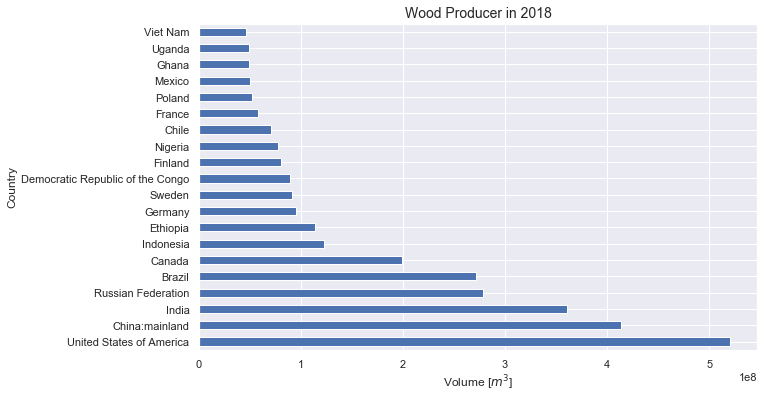

In [44]:
# the biggest producer of wood in 2018
plt.figure(figsize = (10, 6))
wood_production_m3.loc[:, 2018].sort_values(ascending=False).head(20).plot.barh()
plt.title('Wood Producer in 2018', size = 14)
plt.xlabel("Volume [$m^3$]")
plt.ylabel('Country')
plt.show()

> #### ***Explanation***
The deforested/forested area in the country does not seem to be always correlated to the production of wood. We will investigate further the production of the wood in the countries which are leading in both deforesting and increasing the forested areas.

In [45]:
# rank countires by their wood production since 2010
wp_agg = wp_agg.groupby("Area").Value.sum()
wp_agg = wp_agg.to_frame()
wp_agg["rank"] = wp_agg.Value.rank(ascending=False)
wp_agg = wp_agg.reset_index()

In [46]:
# wood production of the top 10 countries by decreased forest area
wp_agg[wp_agg.Area.isin(DEC_FOREST)].sort_values(by='rank')

,Area,Value,rank
23,Brazil,2.431647e+09,4.0
88,Indonesia,1.117080e+09,7.0
51,Democratic Republic of the Congo,7.725738e+08,10.0
136,Nigeria,6.885227e+08,12.0
127,Myanmar,4.068526e+08,20.0
195,United Republic of Tanzania,2.388498e+08,32.0
5,Argentina,1.731315e+08,40.0
145,Paraguay,1.044092e+08,59.0
205,Zimbabwe,8.815796e+07,63.0
20,Bolivia (Plurinational State of),3.449735e+07,103.0


> #### ***Explanation***
Surprisingly, many of the countries leading in the reduction their forests (since 2010) are not one of the biggest producers of the wood in the world.

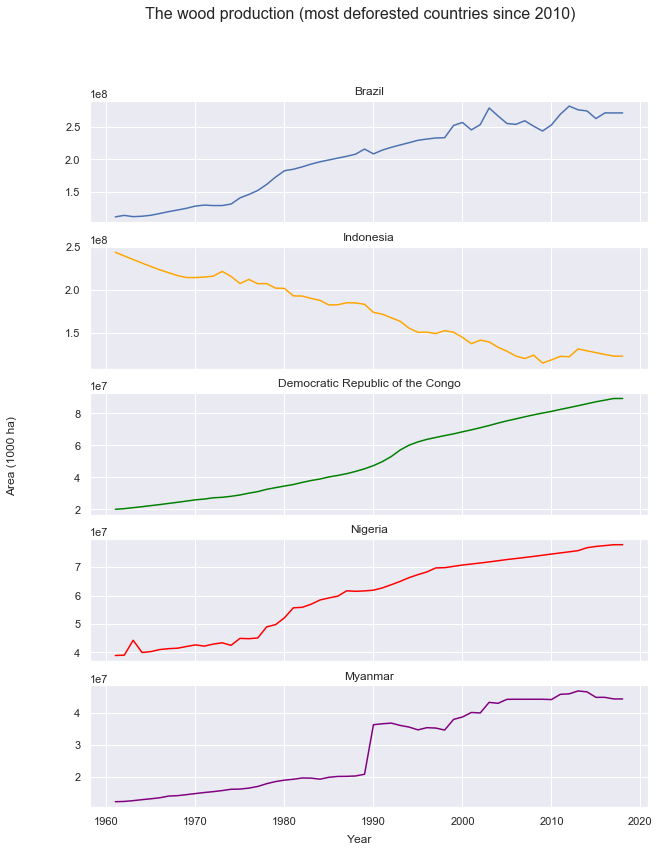

In [47]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))

axes[0].plot(wood_production_m3.loc['Brazil'])
axes[1].plot(wood_production_m3.loc['Indonesia'], color = 'orange')
axes[2].plot(wood_production_m3.loc['Democratic Republic of the Congo'], color = 'green')
axes[3].plot(wood_production_m3.loc['Nigeria'], color = 'red')
axes[4].plot(wood_production_m3.loc['Myanmar'], color = 'purple')
axes[0].set_title('Brazil')
axes[1].set_title('Indonesia')
axes[2].set_title('Democratic Republic of the Congo')
axes[3].set_title('Nigeria')
axes[4].set_title('Myanmar')
fig.suptitle("The wood production (most deforested countries since 2010)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
The countries that have suffered mostly by deforestation since the year 2010 don't seem to be slowing down, except the Indonesia, where is the value of the wood production decreasing year by year. This trend in Indonesia will most likely remain, since there is a big pressure from Indonesian president to reduce the deforestation ([link](https://www.weforum.org/agenda/2019/08/indonesia-president-makes-moratorium-on-forest-clearance-permanent/)).

In [48]:
# wood production of the top 10 countries by increased forest area
wp_agg[wp_agg.Area.isin(INC_FOREST)].sort_values(by='rank')

,Area,Value,rank
196,United States of America,4.285439e+09,1.0
39,China:mainland,3.616067e+09,2.0
87,India,3.269145e+09,3.0
35,Chile,5.871277e+08,14.0
68,France,5.400872e+08,15.0
201,Viet Nam,4.049915e+08,21.0
8,Australia,3.316286e+08,22.0
147,Philippines,1.474655e+08,44.0
102,Lao People's Democratic Republic,8.070786e+07,67.0
71,Gabon,3.374577e+07,105.0


> #### ***Explanation***
USA, China and India have appeared in the list of the top-10 countries which have increased their forested areas, but  these three countries are the biggest producers of the wood in the World!

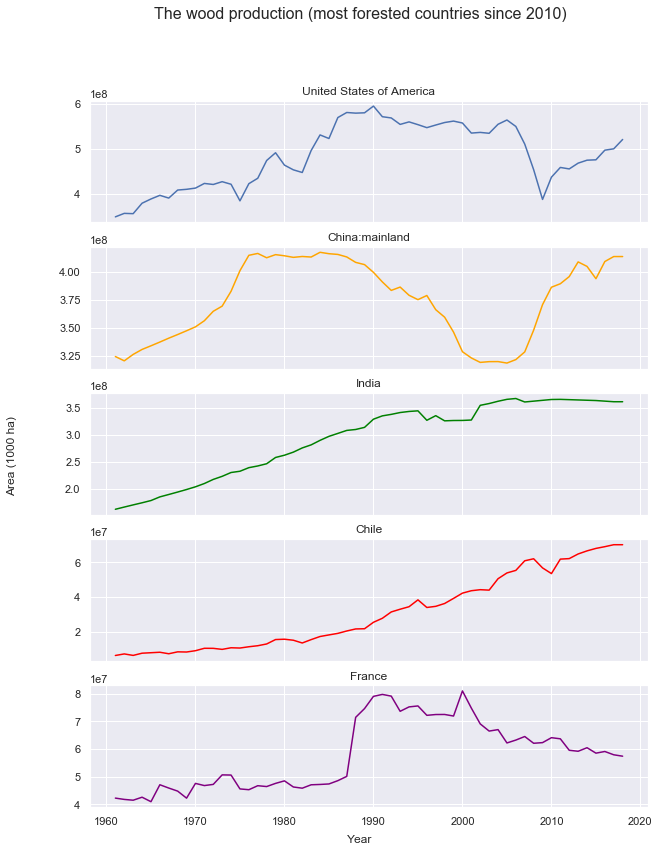

In [49]:
# look deeper for each country
fig, axes = plt.subplots(5, 1, sharex = True, figsize = (10, 13))

axes[0].plot(wood_production_m3.loc['United States of America'])
axes[1].plot(wood_production_m3.loc['China:mainland'], color = 'orange')
axes[2].plot(wood_production_m3.loc['India'], color = 'green')
axes[3].plot(wood_production_m3.loc['Chile'], color = 'red')
axes[4].plot(wood_production_m3.loc['France'], color = 'purple')
axes[0].set_title('United States of America')
axes[1].set_title('China:mainland')
axes[2].set_title('India')
axes[3].set_title('Chile')
axes[4].set_title('France')
fig.suptitle("The wood production (most forested countries since 2010)", fontsize = 16)
fig.text(0.5, 0.087, 'Year', ha = 'center', fontsize = 12)
fig.text(0.01, 0.5, 'Area (1000 ha)', va = 'center', rotation = 'vertical', fontsize = 12)
plt.show()

> #### ***Explanation***
When it comes to the countries where are the forested areas increasing, the value of the wood production are more variated.

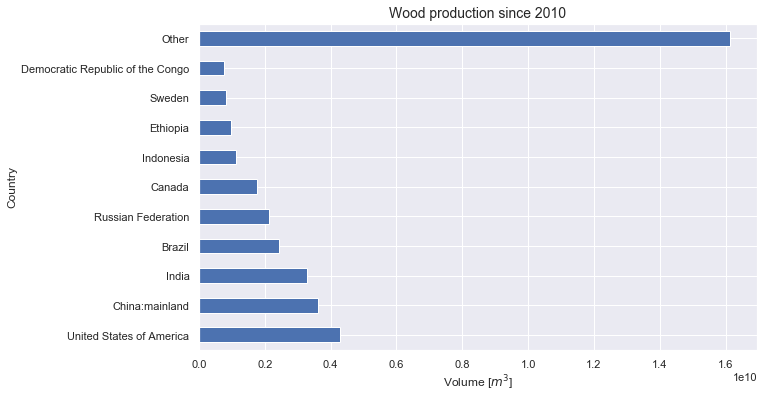

In [50]:
# plot the bar chart describing the wood production in the world since 2010
top_agg = wp_agg.sort_values(by='rank').head(10)[["Area", "Value"]]
oth = {"Area": ["Other"], "Value": [wp_agg.Value.sum() - top_agg.Value.sum()]}
top_agg =top_agg.append(pd.DataFrame.from_dict(oth), ignore_index=True)
top_agg.index = top_agg.Area

top_agg.plot.barh(y="Value", figsize=(10, 6), legend = False)
plt.title("Wood production since 2010", size = 14)
plt.xlabel('Volume [$m^3$]')
plt.ylabel('Country')
plt.show()

> #### ***Explanation***
Only **seven** countries in the world has been responsible for more than 50% produced wood since 2010. This bar chart is much more clear describing how big the share of the big wood producers such as USA, China or India is. 

Here we would like to introduce the map about wood production in each country starting from 2010.

In [51]:
# load county codes and adjust missing values
coutry_codes = FAOSTAT_country_data[["Country", "ISO3 Code"]].drop_duplicates()
coutry_codes.loc[coutry_codes.Country.str.match("China:mainland"), "ISO3 Code"] = "CHN"

# join the codes to the countires
wp_agg['Val_bil'] = wp_agg.Value / 1000000000
wp_map = wp_agg.merge(coutry_codes, how='left', left_on='Area', right_on='Country').drop('Country', axis=1)

# load shapes of the countries and load it to Geopandas
shapefile = 'data/map/ne_110m_admin_0_countries.shp'

# rename columns and drop Antarctica
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf = gdf.drop(gdf.index[159])

# select the most recent year in the data set
#wp_map_2016 = wp_map[wp_map['Year'] == 2016]

# merge dataframes gdf and env_land_use_2016
merged = gdf.merge(wp_map, left_on = 'country_code', right_on = 'ISO3 Code', how = 'left')

# read data to json and convert to String like object
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)

# input GeoJSON source that contains features for plotting
geosource = GeoJSONDataSource(geojson = json_data)
# define a sequential multi-hue color palette.
palette = brewer['YlOrBr'][8]
# reverse color order
palette = palette[::-1]
# instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 4285438664.0)
# define custom tick labels for color bar.

# add hover tool
hover = HoverTool(tooltips = [ ('Country','@country'),('Production (10^9 m^3)', '@Val_bil')])

# create color bar
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')
# create figure object
p = figure(title = 'Wood Production since 2010', plot_height = 600 , plot_width = 950, toolbar_location = None, tools = [hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
# add patch renderer to figure
p.patches('xs','ys', source = geosource,fill_color = {'field' :'Value', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
# specify figure layout
p.add_layout(color_bar, 'below')
# display figure inline in Jupyter Notebook
output_notebook()
# store the plot
export_png(p, filename = 'data/images/wood-production-since-2010.png')
# display figure
show(p)

Loading BokehJS ...

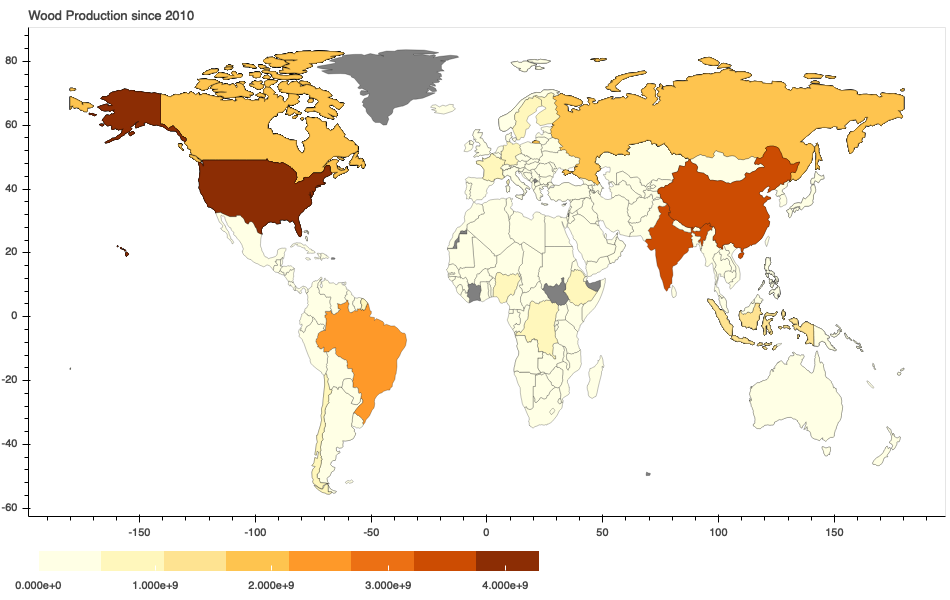

In [52]:
# since we used bokeh, which may not be seen in the notebook originally
# thus, we save the image so that readers could check it anyway
from IPython.display import Image
Image('data/images/wood-production-since-2010.png')

### 2.3 Trade flow
Not only the wood production matters, but which countries have the most demand of woods are also the huge cause of deforestation. Here we would investigate and gain more insights. 

In [53]:
# create dataframe countaining the trade of the wood between countires (in 1000 US$)
trade_all = forest_trade[forest_trade.Element.str.match("Export Value")][["Reporter Countries", "Partner Countries", "Item", "Year", "Unit", "Value"]].rename(columns={"Reporter Countries": "Exporting Country", "Partner Countries": "Importing Country"})

# remove the total vaule of the trades
trade_all= trade_all[~trade_all["Importing Country"].str.match("Total FAO")]

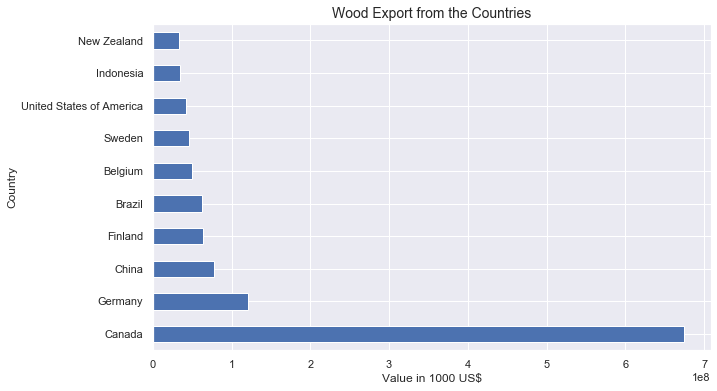

In [54]:
plt.figure(figsize = (10, 6))
trade_all[trade_all["Importing Country"].isin(INC_FOREST)].groupby("Exporting Country").Value.sum().sort_values(ascending=False).head(10).plot.barh()
plt.title('Wood Export from the Countries', size = 14)
plt.xlabel("Value in 1000 US$")
plt.ylabel('Country')
plt.show()

> #### ***Explanation***
As we have been discussing, there are countries with increasing forested areas. We have been wondering if these countries have some big suppliers of the wood. We can see that there is enormous amount of wood coming to them form USA. We will look into this more deeply.

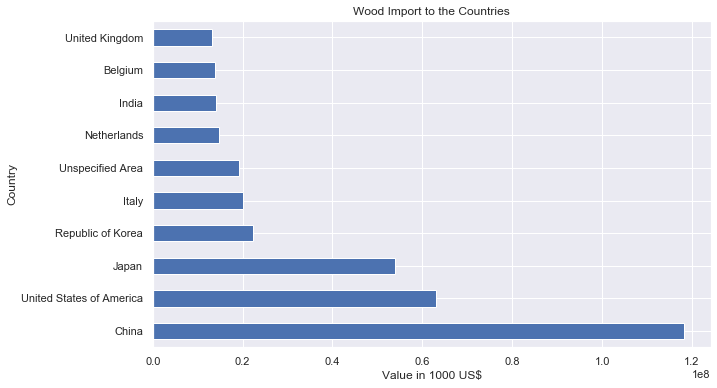

In [55]:
plt.figure(figsize = (10, 6))
trade_all[trade_all["Exporting Country"].isin(DEC_FOREST)].groupby("Importing Country").Value.sum().sort_values(ascending=False).head(10).plot.barh()
plt.title('Wood Import to the Countries')
plt.xlabel("Value in 1000 US$")
plt.ylabel('Country')
plt.show()

> #### ***Explanation***
We have decided to further investigate which countries are importing the wood from the most deforested countries. We an observe that the two biggest producers of the wood are the biggest importers of the wood from this countries.

In [56]:
# the list of biggest wood trade dependecies between countries
trade_all.groupby(["Importing Country", "Exporting Country"]).Value.sum().sort_values(ascending=False).head(20)

Importing Country         Exporting Country       
United States of America  Canada                      650458218.0
Canada                    United States of America    152072318.0
China                     United States of America    128389572.0
Germany                   Sweden                       99776352.0
China                     Russian Federation           94033854.0
Mexico                    United States of America     92689971.0
China                     Canada                       88742165.0
Germany                   Finland                      83120530.0
Japan                     United States of America     74458584.0
United Kingdom            Sweden                       72459379.0
France                    Germany                      71222433.0
Japan                     Canada                       64376362.0
China                     Indonesia                    63083492.0
United Kingdom            Finland                      57070875.0
Germany                  

> #### ***Explanation***
We can see how is the wood trade tied between the biggest Exporters/Importers in the World. We can see how is the USA wood market deepened on the production from Canada.

To see is to believe. Let's visualize the import and export relation of countries.

In [57]:
# load and preprocess trade
forest_trade = pd.read_csv("data/faostat/Forestry_Trade_Flows_E_All_Data_cleared.csv", engine='python')

trade_all = forest_trade[forest_trade.Element.str.match("Export Value") & forest_trade.Item.str.startswith("Forest products")][["Reporter Countries", "Partner Countries", "Item", "Year", "Unit", "Value"]].rename(columns={"Reporter Countries": "Exporting Country", "Partner Countries": "Importing Country"})

# filter countries and year 2015
trade_all = trade_all[trade_all["Exporting Country"].isin(FAOSTAT_countries) & trade_all["Importing Country"].isin(FAOSTAT_countries)]
trade_all = trade_all[trade_all.Year == 2015]

# select most important conections (volume in 1000 US$)
trade_select = trade_all.groupby(["Exporting Country", "Importing Country"]).Value.sum().sort_values(ascending=False).head(35)
trade_select = trade_select.reset_index()
trade_select = trade_select.T

# list of countries in trade
top_cntr = list(set(trade_select.loc["Exporting Country"].values).union(set(trade_select.loc["Importing Country"].values)))

# import and export groups
exp_cntr = list(trade_select.loc["Exporting Country"].values)
imp_cntr = list(trade_select.loc["Importing Country"].values)
vals =  list(trade_select.loc["Value"].values)

# create labels for plot
exp_cntr = [i + " " for i in exp_cntr]
imp_cntr = [i for i in imp_cntr]

# all used countries names
all_cntr = list(set(exp_cntr).union(set(imp_cntr)))

In [58]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = all_cntr,

    ),
    link = dict(
      source = [all_cntr.index(i) for i in exp_cntr], # indices correspond to labels, eg A1, A2, A2, B1, ...
      target = [all_cntr.index(i) for i in imp_cntr],
      value = vals
  ))])

fig.update_layout(font_size=10, width=900, height=600, xaxis_title="x Axis Title")

fig.show()

## **3. Is agricultural industry affect deforestation?**

### **3.1 Plots of area distributions from satellite data**
In this section we used the dataset `Environment_LandCover_E_All_Data_cleared.csv` which contains two types of measurements: CCI_LC and MODIS. The land distribution is inferred from satellite images and aggregated in different (not always perfectly consistent) ways. We want to analyse **changes in different land types with respect to the "ground level" in 1992** (for CCI_LC, or 2001 for MODIS).

In [59]:
env_land_cover_all = pd.read_csv("data/faostat/Environment_LandCover_E_All_Data_cleared.csv", engine='python')

In [60]:
# type of land use: comparison between different land types and deduction of 
# how the forested areas ('Tree-covered ares') transformed

def plot_land_type_differentials_plotly(country, data_type, save_img=False):
    """
    Plots the difference between the yearly surface change (increase or decrease) of different types of land,
    compared to a ground value (1995)
    :param str country:            should match with the 'Area' field
    :param str data_type:          CCI_LC or MODIS, come from different satellite images and different aggregation criteria
    :param bool save_img:          if True, save plot in html
    """

    # create a DataFrame with year as only column. Years listed are from 1995 to 2015
    country_land_types_yearly = pd.DataFrame(np.arange(1995, 2015+1), columns=['Year'])
    
    # fill the DataFrame columns: each column is a specific land type, each row is a year
    land_types = env_land_cover_all.Item.unique()
    for land_type in land_types:
        selected_item_yearly = env_land_cover_all.loc[(env_land_cover_all['Year'] >= 1995) &
                                                      (env_land_cover_all['Year'] <= 2015) &
                                                      (env_land_cover_all['Item'] == land_type) &
                                                      (env_land_cover_all.Area.str.match(country)) &
                                                      (env_land_cover_all.Element.str.match('Area from ' + data_type)), 
                                                      'Value']
        if selected_item_yearly.isnull().sum() == 0: # if the selected land_type is registered every year
            country_land_types_yearly[land_type] = selected_item_yearly.values

    # compute differences w.r.t. first year of measurement for every column
    starting_year = country_land_types_yearly.iloc[0, 0]
    country_land_types_year_diff = country_land_types_yearly - country_land_types_yearly.iloc[0, :]
    country_land_types_year_diff['Year'] = country_land_types_year_diff['Year'] + starting_year    # restore correct year after subtraction

    # set 'Year' as the new index
    country_land_types_year_diff.set_index('Year', inplace=True)

    # select classes of land type
    selected_land_types = land_types[[1, 2, 4, 5, 7]]
    
    # take most important 5 land types (based on differential values) and check if they are plotted
    top_n_land_types = country_land_types_year_diff.iloc[-1, :].abs().sort_values(ascending=False).index[0:len(selected_land_types)]
    for land_type in top_n_land_types:
        if land_type not in selected_land_types:
            print("Warning: " + land_type + " was not plotted but had big differential value!")
            
    # plot
    fig = go.Figure()
    
    # reference horizontal line
    fig.add_shape(
        go.layout.Shape(type="line", 
                        x0=country_land_types_year_diff.index.values[0], 
                        y0=0, 
                        x1=country_land_types_year_diff.index.values[-1], 
                        y1=0, 
                        line=dict(color="Black", width=1, dash="dashdot")
        )
    )
    
    for column_index, land_type in enumerate(country_land_types_year_diff.columns):
        
        # skip land types that were not selecte (cleaner plot!)
        if land_type not in selected_land_types:
            continue

        fig.add_trace(go.Scatter(x=country_land_types_year_diff.index,
                                 y=country_land_types_year_diff[land_type],
                                 mode='lines',
                                 name=land_type))

    fig.update_layout(
#         title=country + " land use differentials (" + data_type + " data)",  # no title for final data story
        xaxis_title='Year',
#         yaxis_title='Differential surface w.r.t. ' + \
#             str(int(country_land_types_year_diff.index[0])) + \
#             ' value [1000 ha]',
        yaxis_title='Change w.r.t. 1995 [1000 ha]',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        annotations=[
        go.layout.Annotation(
            x=2013,
            y=0,
            xref="x",
            yref="y",
            text="Reference (1995)",
            showarrow=True,
            arrowsize=1,
            arrowhead=1,
            align="center",
            arrowwidth=1,
            ax=-10,
            ay=30,
        )
        ]
    )
    
    fig.update_layout(legend_orientation="h")
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    
    fig.show()
    
    if save_img:
        py.offline.plot(fig, filename='land_satellite_data_' + str(country) + '.html')

In [61]:
COUNTRY = 'Chile'
plot_land_type_differentials_plotly(COUNTRY, 'CCI_LC', save_img=False)

> #### ***Explanation***
>
> Here we represented plots for Brazil and Indonesia (which are among the biggest deforested countries) and USA (which, instead, increased the forest land).
>
> + **BRAZIL**: big decrease in tree-covered areas, compensated by creation of **new grasslands and fields of herbaceous crops** (Brazil agriculture is mostly based on **sugar cane**).
> + **INDONESIA**: in this case also herbaceous crops fields decrease to compensate the **increase of woody crops** (cultivated trees). This is linked to the main product of indonesian agriculture: **palm oil**.
> + **UNITED STATES OF AMERICA**: in this case tree-covered areas increased **subtracting land to shrubs** and other small vegetation lands.

### *3.2 Link between yield of agricultural land and deforestation*
Here we try to check if agricultural yield can be used useful in classifying the countries in de- and re-foresting ones.

In [62]:
# select forestation related features from Inputs_LandUse 
land_use_all = pd.read_csv("data/faostat/Inputs_LandUse_E_All_Data_cleared.csv", engine='python')
land_use = land_use_all[land_use_all.Item.isin(['Forestry']) &
                        land_use_all.Element.str.match('Area')]

# change Area USSR to Russian Federation
land_use.Area = np.where(land_use['Area'] == 'USSR', 'Russian Federation', land_use.Area)

In [63]:
prod_crops_all = pd.read_csv("data/faostat/Production_Crops_E_All_Data_cleared.csv", engine='python')

In [64]:
# top 10 deforested countries (criterion: surface of forest losses)
all_countries_forests_area_1990 = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                               land_use_all.Element.str.match('Area') &
                                               (land_use_all.Year == 1990)]

all_countries_forests_area_2017 = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                               land_use_all.Element.str.match('Area') &
                                               (land_use_all.Year == 2017)]

# drop aggregated rows
all_countries_forests_area_1990 = all_countries_forests_area_1990[all_countries_forests_area_1990['Area Code'] < 5000]
all_countries_forests_area_2017 = all_countries_forests_area_2017[all_countries_forests_area_2017['Area Code'] < 5000]

# join dataframes
deforestation_1990_2017 = all_countries_forests_area_1990.merge(all_countries_forests_area_2017, 
                                                                left_on=['Area Code', 'Area'], 
                                                                right_on=['Area Code', 'Area'])

# compute deforested areas
deforestation_1990_2017.loc[:, 'Forest land differential'] = deforestation_1990_2017['Value_y'] - deforestation_1990_2017['Value_x']
deforestation_1990_2017 = deforestation_1990_2017.loc[:, ['Area', 'Forest land differential']]\
                                                 .sort_values(by=['Forest land differential'], 
                                                              ascending=False)

# extract name of top 10 countries for de- and re-forestation
top_10_deforested_countries = deforestation_1990_2017.tail(10).sort_values(by=['Forest land differential']).Area
top_10_reforested_countries = deforestation_1990_2017.head(11).Area
top_10_reforested_countries = top_10_reforested_countries.drop(38) # drop China:mainland

# get time series for those countries
top_10_deforested_countries_yearly = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                                  land_use_all.Element.str.match('Area') &
                                                  land_use_all.Area.isin(top_10_deforested_countries)]
top_10_reforested_countries_yearly = land_use_all[land_use_all.Item.str.match('Forestry') &   
                                                  land_use_all.Element.str.match('Area') &
                                                  land_use_all.Area.isin(top_10_reforested_countries)]

In [65]:
# Correlation between low yield and high deforestation.
# The field 'Yield' in the 'Element' column of the dataframe is computed
# as 'Production' / 'Area Harvested' and measured in hg/ha
def yield_differences_in_top_10s(ITEM, YEAR):
    deforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_deforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values = prod_crops_all.loc[(prod_crops_all.Area.isin(top_10_reforested_countries)) &
                                           (prod_crops_all.Item == ITEM) &
                                           (prod_crops_all.Year == YEAR) &
                                           (prod_crops_all.Element == 'Yield')]\
                                      .loc[:, ['Value', 'Area']]

    reforested_values['Deforested'] = 0
    reforested_values['Color'] = 'royalblue'
    deforested_values['Deforested'] = 1
    deforested_values['Color'] = 'orange'
    all_values = pd.concat([deforested_values, reforested_values], axis=0)
    all_values = all_values.sort_values(by=['Value'])

    # print(ITEM + ' yield:\n' +
    #       str(deforested_values.Value.mean()) + ' (mean over ' + str(deforested_values.Value.count()) + ' countries in top 10 deforested)\n' + 
    #       str(reforested_values.Value.mean()) + ' (mean over ' + str(reforested_values.Value.count()) + ' countries in top 10 reforested)')

    plt.figure(figsize=(9, 6))
    for country in all_values.Area:
        plt.barh(country, all_values.loc[all_values.Area == country, 'Value'], color=all_values.loc[all_values.Area == country, 'Color'])
    plt.legend(['reforested (== blue)', 'deforested (== orange)'])
    plt.title(ITEM + ' yield in top 10 reforested and deforested countries (year ' + str(YEAR) + ')')
    plt.gca().set_xlabel('Yield [hg/ha]')
    plt.show()

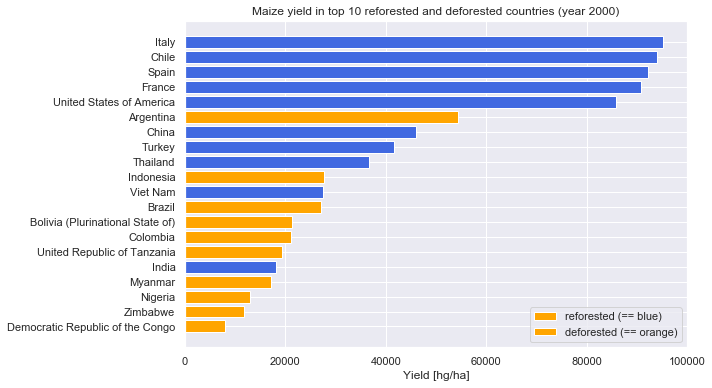

In [66]:
yield_differences_in_top_10s('Maize', 2000)

> #### ***Explanation***
> Countries that **increased their forest land** (USA, Chine, Thailand, France, Spain...) have usually a much **bigger yield**. Yield is computed as production over area harvested and it is than measured in hg/ha. This can be interpreted as: **better productivity means less need of agriculture land** to product the same quantity, alleviating the need of new lands to cultivate. Anyway **this conclusion is weak** since the clear correlation exibithed in the previous plots can be explained also by a more general cause: deforesting countries are on average less rich than the ones that increase tree coverage; **richer countries have access to better agricultural practices** that increase productivity (e.g. check for India, developing country, which has low productivity scores).

### *3.3 PCA: clustering of the countries based on agricultural production share*
In this section we want to **understand if the deforesting countries have similar agriculture styles**. A matrix containing countries (as rows) and **shares in agricultural production** of each type of product (each item is a column) is used as a representation of different agriculture styles.

+ In this section **PCA** is used to classify the countries based on their agricultural production in a 2D space **without satisfactory results**. 

In [67]:
# compute the share of each agriculture item for every country, selected year
YEAR = 2015

countries_production_total = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                           .groupby(['Area', 'Year'])\
                                           .sum()\
                                           .rename({'Value': 'Total Yearly Production'}, axis='columns')\
                                           .loc[:, 'Total Yearly Production']

countries_production_shares = prod_crops_all.loc[(prod_crops_all.Element == 'Production')]\
                                            .merge(countries_production_total, right_index=True, left_on=['Area', 'Year'])

countries_production_shares['Yearly Share'] = 100 * countries_production_shares['Value'] / countries_production_shares['Total Yearly Production']

# remove aggregated areas
countries_production_shares = countries_production_shares.loc[countries_production_shares['Area Code'] < 5000]

# select a single year
shares_single_year = countries_production_shares.loc[countries_production_shares.Year == YEAR]

In [68]:
# load agricultural share matrix from file
production_shares_matrix = pd.read_pickle("data/production_shares_matrix.pkl")

In [69]:
# Products for single country
COUNTRY = 'Brazil'
prod_crops_all.loc[(prod_crops_all.Element == 'Production') & 
                   (prod_crops_all.Area == COUNTRY) &
                   (prod_crops_all.Year == 2015)].head(5)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
186889,21,Brazil,515,Apples,5510,Production,2015,2015,tonnes,1264651.0,NaN
187060,21,Brazil,572,Avocados,5510,Production,2015,2015,tonnes,180652.0,NaN
187231,21,Brazil,486,Bananas,5510,Production,2015,2015,tonnes,6859227.0,NaN
187402,21,Brazil,44,Barley,5510,Production,2015,2015,tonnes,186285.0,NaN
187573,21,Brazil,782,Bastfibres:other,5510,Production,2015,2015,tonnes,4917.0,NaN


In [70]:
# Production share for single country
COUNTRY = 'Thailand'    # 'United States of America'
country_shares = production_shares_matrix[production_shares_matrix.index == COUNTRY].values[0]
country_shares_df = pd.DataFrame(country_shares, columns=['Share'], index=production_shares_matrix.columns)
country_shares_df.loc[country_shares_df.Share > 1, 'Share'].sort_values(ascending=False)

Sugar cane                    31.4199
Roots and Tubers:Total        10.9684
Cereals:Total                 10.9468
Cassava                       10.7998
Rice:paddy                    9.24595
Cereals (Rice Milled Eqv)     7.86786
Oil palm fruit                3.69099
Fruit Primary                 3.56633
Coarse Grain:Total            1.70039
Maize                         1.57854
Rubber:natural                 1.4906
Mangoes:mangosteens:guavas     1.1118
Name: Share, dtype: object

In [71]:
# show a sample of the matrix used for clustring
production_shares_matrix.iloc[0:4, 0:4]

,Almonds:with shell,Anise:badian:fennel:coriander,Apples,Apricots
Afghanistan,0.0976835,0.0725193,0.361521,0.353274
Albania,0,0,1.45978,0.0802803
Algeria,0.157873,0,0.931925,0.605811
American Samoa,0,0,0,0


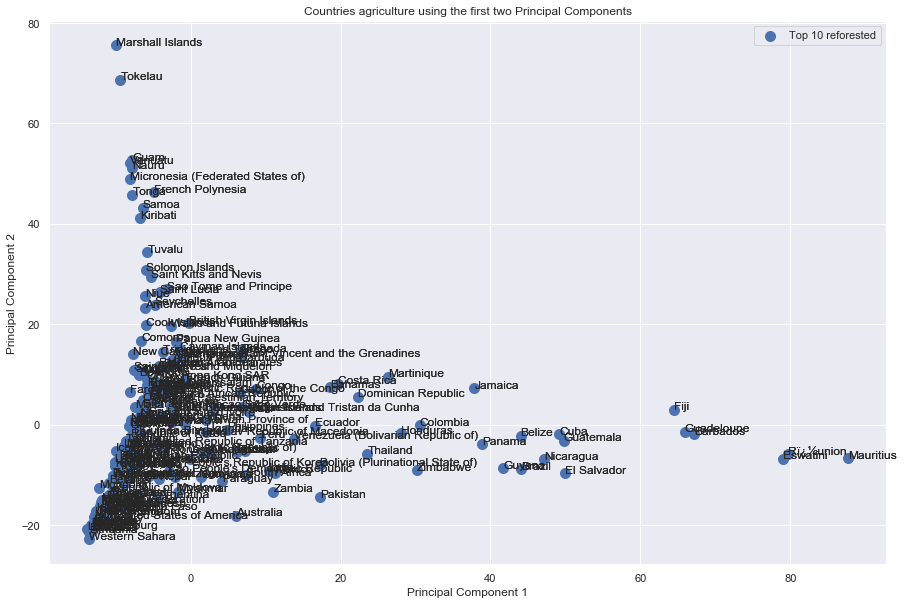

In [72]:
from sklearn.decomposition import PCA

# PCA on the whole agricultural share matrix (all countries)

# matrix rows are countries, columns are products; values are shares (%) of total yearly production
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(production_shares_matrix.values)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# plot results in 2D and look for clusters
plt.figure(figsize=(15, 10))
plt.scatter(principalDf.PC1, principalDf.PC2, marker='o', s=100)
# add country names to the plot
for i, country in enumerate(production_shares_matrix.index.values):
    plt.annotate(country, (principalDf.PC1[i], principalDf.PC2[i]))
for i, country in enumerate(production_shares_matrix.index.values):
    plt.annotate(country, (principalDf.PC1[i], principalDf.PC2[i]))
plt.title('Countries agriculture using the first two Principal Components')
plt.gca().set_xlabel('Principal Component 1')
plt.gca().set_ylabel('Principal Component 2')
plt.legend(['Top 10 reforested', 'Top 10 deforested'])
plt.show()

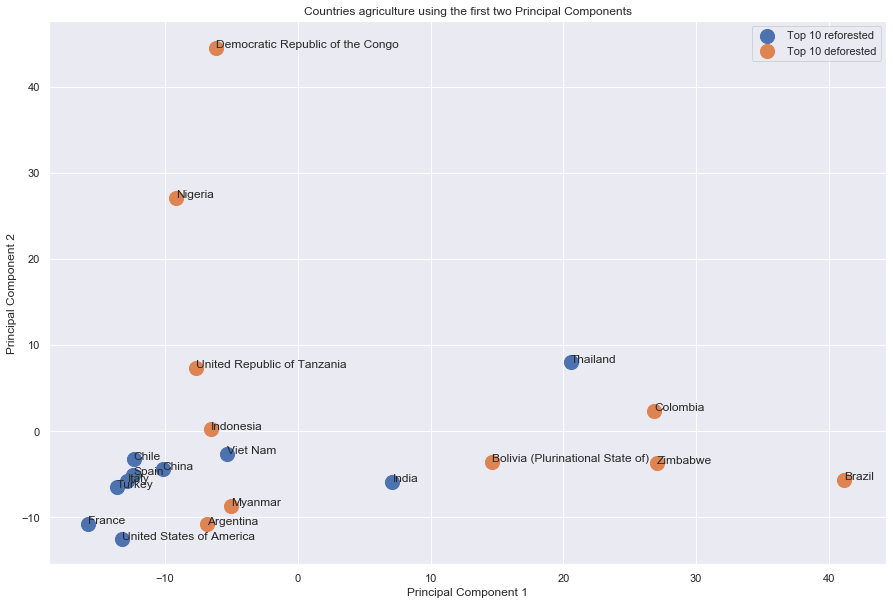

In [73]:
from sklearn.decomposition import PCA

# PCA on top 10 re- and de-forester countries

# compute the reduced matrix (only 20 countries from the two top 10) before applying SVD
reduced_production_shares_matrix = production_shares_matrix.loc[production_shares_matrix.index.isin(top_10_deforested_countries.values.tolist() + 
                                                                                                    top_10_reforested_countries.values.tolist())]

# find top 10 re- and de-forester countries indices (rows) in the matrix
reduced_deforester_indices = []
reduced_reforester_indices = []
for i in range(0, reduced_production_shares_matrix.shape[0]):
    if reduced_production_shares_matrix.index[i] in top_10_deforested_countries.values:
        reduced_deforester_indices.append(i)
    elif reduced_production_shares_matrix.index[i] in top_10_reforested_countries.values:
        reduced_reforester_indices.append(i)
        
# matrix rows are countries, columns are products; values are shares (%) of total yearly production
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(reduced_production_shares_matrix.values)
principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# plot results in 2D and look for clusters
plt.figure(figsize=(15, 10))
plt.scatter(principalDf.PC1[reduced_reforester_indices], principalDf.PC2[reduced_reforester_indices], marker='o', s=200)
plt.scatter(principalDf.PC1[reduced_deforester_indices], principalDf.PC2[reduced_deforester_indices], marker='o', s=200)
# add country names to the plot
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_reforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_reforester_indices[i]], principalDf.PC2[reduced_reforester_indices[i]]))
for i, country in enumerate(reduced_production_shares_matrix.index.values[reduced_deforester_indices]):
    plt.annotate(country, (principalDf.PC1[reduced_deforester_indices[i]], principalDf.PC2[reduced_deforester_indices[i]]))
plt.title('Countries agriculture using the first two Principal Components')
plt.gca().set_xlabel('Principal Component 1')
plt.gca().set_ylabel('Principal Component 2')
plt.legend(['Top 10 reforested', 'Top 10 deforested'])
plt.show()

In [74]:
# first 10 singular values
N = 5
pca_singular_values = PCA(n_components=N)
pca_singular_values.fit_transform(reduced_production_shares_matrix.values)
print("First " + str(N) + " singular values:\n", pca_singular_values.singular_values_, end='\n\n')

# variance explanation ratio for each singular value
print("Variance explanation of the first " + str(N) + " singular values:\n", pca_singular_values.explained_variance_ratio_)

First 5 singular values:
 [73.09122664 59.47589432 36.79460944 31.44658291 24.02238777]

Variance explanation of the first 5 singular values:
 [0.41421918 0.27427212 0.1049707  0.07667374 0.04474372]


>#### ***Explanation***
> **PCA** is used to classify the countries based on their agricultural production in a 2D space.
> + Pros:
>
>   + Simple **visual** clustering.
>
>   + **Deforesting countries** (orange) **have a more spread distribution** and are on average far from the blue cluster of countries that increase forest land. 
>
> + Cons: 
>
>   + **Lack of interpretability** since the dimensions does not have a physical meaning.
>
>   + The clustering in two classes is far from perfect.
>   
>   + The difference between the two biggest singular values and the others is not so high (the third is about half the second): **not-negligible variations are thrown away** with just 2 dimensions.

### 3.4 *Graph: clustering of the countries based on agricultural production share*
In this section we want to **understand if the deforesting countries have similar agriculture styles**. A matrix containing countries (as rows) and **shares in agricultural production** of each type of product (each item is a column) is used as a representation of different agriculture styles.

+ A **graph representation on map** is presented, computing the (cosine) distance between countries in the agriculture shares space. **More intuitive** interpretation is possible is this case. This improves the PCA visualization in the previous section.

In [75]:
# distance between two countries in agricultural share space
def compute_distance(country_1, country_2):
    country_1_agricultural_share = np.array(production_shares_matrix.loc[country_1, :].values)
    country_2_agricultural_share = np.array(production_shares_matrix.loc[country_2, :].values)
    cosine_similarity = np.dot(country_1_agricultural_share, country_2_agricultural_share) / \
                        (np.linalg.norm(country_1_agricultural_share) * np.linalg.norm(country_2_agricultural_share))
    return 1 - cosine_similarity

In [76]:
# compute (cosine) distance matrix between top 10 re- and de-forested
distance_matrix = np.zeros((20, 20))
the_20_countries = top_10_reforested_countries.append(top_10_deforested_countries)
for i, country_1 in enumerate(the_20_countries):
    for j, country_2 in enumerate(the_20_countries):
        distance_matrix[i, j] = compute_distance(country_1, country_2)
distances = pd.DataFrame(data=distance_matrix,
                         index=the_20_countries,
                         columns=the_20_countries)
# set 0 on diagonal (sometimes is 2e-16)
for i in range(20):
    distances.iloc[i, i] = 0

In [77]:
# graph plot setup:
# - baricenters of countries
# - colors
# - sizes of bubbles

# baricenters of countries, used for plotting the graph
countries_centers = pd.DataFrame([['China', 35.86166, 104.195397], 
                                  ['United States of America', 37.09024, -95.712891],
                                  ['India', 20.593684, 78.96288],
                                  ['Viet Nam', 14.058324, 108.277199], 
                                  ['Spain', 40.463667, -3.74922],
                                  ['France', 46.227638, 2.213749], 
                                  ['Chile', -35.675147, -71.542969],
                                  ['Thailand', 15.870032, 100.992541], 
                                  ['Turkey', 38.963745, 35.243322],
                                  ['Italy', 41.87194, 12.56738], 
                                  ['Brazil', -14.235004, -51.92528], 
                                  ['Indonesia', -0.789275, 113.921327],
                                  ['Nigeria', 9.081999, 8.675277],
                                  ['Myanmar', 21.913965, 95.956223], 
                                  ['United Republic of Tanzania', -6.369028, 34.888822],
                                  ['Zimbabwe', -19.015438, 29.154857], 
                                  ['Bolivia (Plurinational State of)', -16.290154, -63.588653],
                                  ['Democratic Republic of the Congo', -4.038333, 21.758664], 
                                  ['Argentina', -38.416097, -63.616672],
                                  ['Colombia', 4.570868, -74.297333]],
                                 columns=['Area', 'Latitude', 'Longitude'])
countries_centers = countries_centers.set_index('Area')

# colors
reforested_color = '#1f77b4'
deforested_color = '#ff7f0e'
colors = []
for i in range(10):
    colors.append(reforested_color)
for i in range(10):
    colors.append(deforested_color)

# extract forest land differential and use it to define the scale of the bubbles
top_10_reforested_sizes = deforestation_1990_2017.head(11)\
                                                 .drop(38)\
                                                 .loc[:, 'Forest land differential']\
                                                 .tolist()
top_10_deforested_sizes = deforestation_1990_2017.tail(10)\
                                                 .sort_values(by=['Forest land differential'])\
                                                 .loc[:, 'Forest land differential']\
                                                 .tolist()
top_10_deforested_sizes = np.abs(top_10_deforested_sizes).tolist()  # differentials for deforested are negative

# rescale using 
sizes = top_10_reforested_sizes + top_10_deforested_sizes
sizes = np.array(sizes) / np.max(sizes)
sizes = np.log(sizes + 1)

# final absolute scale to match plotly parameters
scale = 50
for i in range(len(sizes)):
    sizes[i] = sizes[i] * scale

In [78]:
# plot the graph on map
fig = go.Figure()

# add bubbles representing forest land differential between 1990 and 2017 for selected countries
for area_index, Area in enumerate(countries_centers.index):

    show_legend = False
    legend_label = ''
    
    fig.add_trace(go.Scattergeo(
            lon = [countries_centers.loc[Area, 'Longitude']],
            lat = [countries_centers.loc[Area, 'Latitude']],
            hoverinfo = 'text',
            text = Area,
            mode = 'markers',
            marker = dict(
                size = sizes[area_index],
                color = colors[area_index],
                opacity = 1,
                line = dict(
                    width = 3,
                    color = 'rgba(68, 68, 68, 0)'
                    )
                ),
            name=legend_label,
            showlegend=show_legend
            )
        )

# add connections between countries based on distance in agricultural production share
connections = []
for i, country_1 in enumerate(the_20_countries):
    for j, country_2 in enumerate(the_20_countries):
        
        # skip diagonal
        if country_1 == country_2:
            continue
            
        # threshold for distance
        distance = distances.loc[country_1, country_2]
        if distance > 0.2:
            continue
        
        # set color for connection
        if (country_1 in top_10_reforested_countries.tolist()) & (country_2 in top_10_reforested_countries.tolist()):
            line_color = reforested_color
            opacity_ = 0.4
        elif (country_1 in top_10_deforested_countries.tolist()) & (country_2 in top_10_deforested_countries.tolist()):
            line_color = deforested_color
            opacity_ = 0.4
        else:
            line_color = 'rgb(86, 101, 115)'
            opacity_ = 0.2
            
        # add connection
        fig.add_trace(
            go.Scattergeo(
                lon = [countries_centers.loc[country_1].Longitude, countries_centers.loc[country_2].Longitude],
                lat = [countries_centers.loc[country_1].Latitude, countries_centers.loc[country_2].Latitude],
                mode = 'lines',
                line = dict(width = 0.3/distance, color = line_color),
                opacity = opacity_,
                name=legend_label,
                showlegend=show_legend
            )
        )
        
# set white background for countries      
fig.update_layout(
    title_text = '',
    geo = go.layout.Geo(
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
    width=800,
    height=500,
)

fig.show()

# save figure to embed it in html page
# py.offline.plot(fig, filename='agricultural_similarity.html')  

> ### **Explanation**
> Land use, with particular attention to the type of products cultivated on agriculture land, can be an interesting perspective from which to look at the problem at hand. Analysing the 20 countries that had the biggest differential in forest land between 1990 and 2015 (10 positive, reforesting; 10 negative, diminishing forest land) it can be observed how the agricultural style of a country is often linked to the effort of expanding tree covered areas. China, which has the highest positive impact on reforestation all over the world, shares many agrarian products with european nations that are also expanding forested areas; similar agricultural organization and ecological policy can be found in Chile, despite being it geographically closer to Argentina, Bolivia, Brazil and Colombia. Intresting facts are that Zimbabwe has farming style particularly similar to the last three aforementioned countries, while among african nations (all characterized by a decrease in forest land in the analysed time span) only a quite weak bound can be seen between Nigeria and DRC. At last, in the Middle East area interesting facts happen: Thailand has, from the farming perspective, a profile much closer to deforesting countries, not sharing many products with first mentioned group, the european one, even if it has a positive forest land differential; Myanmar and Vietnam are very close from the agricultural point of view but far for what concerns foresting policies; Indonesia has a unique farming style.

### 3.5 *Compare agriculture and forest land change in time*

In [79]:
CONTINENTS = ['Africa', 'Asia', 'Oceania', 'Europe', 'Northern America', 'South America', 'Antarctic Region']
AGRICULTURE_LAND_USE_ITEMS = ['Agricultural land', 'Cropland', 'Land under perm. meadows and pastures']
FOREST_LAND_USE_ITEMS = ['Forestry']

In [80]:
land_use = land_use_all[(land_use_all.Item.isin(AGRICULTURE_LAND_USE_ITEMS) | 
                        land_use_all.Item.isin(FOREST_LAND_USE_ITEMS)) &
                        land_use_all.Element.str.match('Area') &
                        land_use_all.Area.isin(CONTINENTS)]

In [81]:
# check for Oceania meadows and pastures abrupt decrease
oceania_meadows_pastures_1995 = land_use_all[(land_use_all.Area == 'Oceania') &
                                         (land_use_all.Year == 1995) &
                                         (land_use_all.Item == 'Land under perm. meadows and pastures')].Value.values

oceania_meadows_pastures_2015 = land_use_all[(land_use_all.Area == 'Oceania') &
                                         (land_use_all.Year == 2015) &
                                         (land_use_all.Item == 'Land under perm. meadows and pastures')].Value.values

oceania_meadows_pastures_diff = oceania_meadows_pastures_2015 - oceania_meadows_pastures_1995
print("In Oceania 'Land under perm. meadows and pastures' dropped by", 1000*oceania_meadows_pastures_diff[0], 
      "ha between 1995 and 2015")

In Oceania 'Land under perm. meadows and pastures' dropped by -132819000.0 ha between 1995 and 2015


> ### ***Explanation***
> **Oceania lost a huge amount of meadows and pastures**. This value is very big compared to all the other differentials computed for other countries. **Bush fires in Australia are not enough to explain such a high value** (land losses are at least one order of magnitude smaller looking them up on [Wikipedia dedicated page](https://en.wikipedia.org/wiki/Bushfires_in_Australia). Moreover, no significant news are found about catastrophic events in this sense and FAO description of the dataset does not provide additional information on this. We then suppose that, somehow, there is an **inconsistency in the dataset**.

In [82]:
YEAR_MIN = 1995
YEAR_MAX = 2015
YEARS_BLOCKS = 4  # aggregate YEARS_BLOCKS years in the slider
SUBPLOTS = False

fig = go.Figure()

if SUBPLOTS:
    fig = plotly.subplots.make_subplots(
        rows=1, 
        cols=3,
        subplot_titles=("Cropland", "Meadows and pastures", "Forested Area"),
        shared_yaxes=True
    )
else:
    fig = plotly.subplots.make_subplots(
        rows=1, 
        cols=1,
#         subplot_titles=("Forested and agricultural land differentials", " "),
        shared_yaxes=True
    )

agriculture_land_baseline = land_use[(land_use.Year == YEAR_MIN) & 
                                (land_use.Item.isin(AGRICULTURE_LAND_USE_ITEMS))]
forest_land_baseline = land_use[(land_use.Year == YEAR_MIN) &
                           (land_use.Item.isin(FOREST_LAND_USE_ITEMS))]

for year in np.arange(YEAR_MIN, YEAR_MAX+1, YEARS_BLOCKS):
    agriculture_land = land_use[(land_use.Year == year) & 
                                (land_use.Item.isin(AGRICULTURE_LAND_USE_ITEMS))]
    forest_land = land_use[(land_use.Year == year) &
                           (land_use.Item.isin(FOREST_LAND_USE_ITEMS))]
    
    # Total forest land
    # AGRICULTURE_LAND_USE_ITEMS[0] not used...
    
    # Cropland
    subplot_col = 1
    fig.add_trace(
        go.Bar(
            y=agriculture_land[agriculture_land.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[1])].Area.values,
            x=agriculture_land[agriculture_land.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[1])].Value.values -
              agriculture_land_baseline[agriculture_land_baseline.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[1])].Value.values,
            name='Cropland',
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=subplot_col,
    )
    
    # Land under perm. meadows and pastures
    if SUBPLOTS:
        subplot_col = 2
    fig.add_trace(
        go.Bar(
            y=agriculture_land[agriculture_land.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[2])].Area.values,
            x=agriculture_land[agriculture_land.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[2])].Value.values -
              agriculture_land_baseline[agriculture_land_baseline.Item.str.match(AGRICULTURE_LAND_USE_ITEMS[2])].Value.values,
            name='Meadows, pastures',
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=subplot_col,
    )
    
    # Forest land
    if SUBPLOTS:
        subplot_col = 3
    fig.add_trace(
        go.Bar(
            y=forest_land[forest_land.Item.str.match(FOREST_LAND_USE_ITEMS[0])].Area.values,
            x=forest_land[forest_land.Item.str.match(FOREST_LAND_USE_ITEMS[0])].Value.values -
              forest_land_baseline[forest_land_baseline.Item.str.match(FOREST_LAND_USE_ITEMS[0])].Value.values,
            name='Forest land',
            orientation='h',
            visible=False,
        ),    
        row=1,
        col=subplot_col,
    )
    

# Add interactivity (slider)
traces_number = 3    # how many categories (bars)

for trace in range(traces_number):
    fig.data[trace].visible = True

steps = []
for i in range(int(len(fig.data)/traces_number)):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
        label='{}'.format(YEARS_BLOCKS*i + YEAR_MIN),
    )
    for trace in range(traces_number):
        step["args"][1][i*traces_number + trace] = True
    steps.append(step)

sliders = [dict(
    active=1992,
    currentvalue={"prefix": "Year: "},
#     pad={"t": 0},
    steps=steps
)]
fig.update_layout(
    sliders=sliders,
    xaxis_title='Change w.r.t. 1995 (1000 ha)',
#     barmode='stack',
    autosize=False,
    width=700,
    height=600,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    
)
fig.update_xaxes(showgrid=True, gridcolor="LightGray", range=[-1.5e5, 1.5e5])

fig.show()
# py.offline.plot(fig, filename='land_forest_vs_agriculture.html')

> ### **Explanation**
> Land use, with particular attention to the type of products cultivated on agriculture land, can be an interesting perspective from which to look at the problem at hand. Analysing the 20 countries that had the biggest differential in forest land between 1990 and 2015 (10 positive, reforesting; 10 negative, diminishing forest land) it can be observed how the agricultural style of a country is often linked to the effort of expanding tree covered areas. China, which has the highest positive impact on reforestation all over the world, shares many agrarian products with european nations that are also expanding forested areas; similar agricultural organization and ecological policy can be found in Chile, despite being it geographically closer to Argentina, Bolivia, Brazil and Colombia. Intresting facts are that Zimbabwe has farming style particularly similar to the last three aforementioned countries, while among african nations (all characterized by a decrease in forest land in the analysed time span) only a quite weak bound can be seen between Nigeria and DRC. At last, in the Middle East area interesting facts happen: Thailand has, from the farming perspective, a profile much closer to deforesting countries, not sharing many products with first mentioned group, the european one, even if it has a positive forest land differential; Myanmar and Vietnam are very close from the agricultural point of view but far for what concerns foresting policies; Indonesia has a unique farming style.

**Note**: Oceania will be removed from the plot shown in datastory because of the aforementioned inconsistency.

## 4. Reforestation

In [83]:
# helpful functions to extract first and last non-null values
def first(x):
    if x.first_valid_index() is None:
        return None
    else:
        return x[x.first_valid_index()]
    
def last(x):
    if x.last_valid_index() is None:
        return None
    else:
        return x[x.last_valid_index()]

In [84]:
# foreseted areas (ha) for every contry per year
forested_area_yearly = land_use[land_use.Area.isin(country_continent)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_unstack = forested_area_yearly.unstack("Year")
forested_area_yearly_country = land_use[land_use.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
forested_area_yearly_country_unstack = forested_area_yearly_country.unstack("Year")

In [85]:
forested_areas_diff_20yr = -forested_area_yearly_country_unstack.iloc[:,5:26].apply(last, axis=1) + forested_area_yearly_unstack.iloc[:,5:26].apply(first, axis=1)

In [86]:
# top 5 deforestating countries in this two decades
df_top5=forested_areas_diff_20yr.sort_values(ascending=False).head(5)

In [87]:
# summation of other countries' deforestated areas
df = forested_areas_diff_20yr.sort_values(ascending=False)
df = (df + abs(df))/2
df.dropna().sum() - df_top5.sum()

0.0

In [88]:
# top 5 deforestating countries in this two decades
rf_top5=-forested_areas_diff_20yr.sort_values(ascending=True).head(5)

In [89]:
# summation of other countries' reforestated areas
rf = -forested_areas_diff_20yr.sort_values(ascending=True)
rf = (rf + abs(rf))/2
rf.dropna().sum() - rf_top5.sum()

0.0

In [90]:
# stacked barchart of top5 deforestated countries and sum of others
tx = ['Deforestation','Reforestation']
fig = go.Figure(go.Bar(x=['Deforestation'], y=[103904],text=['Others'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # other
fig.add_trace(go.Bar(x=['Deforestation'], y=[7860],text=['Tanzania'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # United Republic of Tanzania Viet Nam
fig.add_trace(go.Bar(x=['Deforestation'], y=[8002],text=['Myanmar'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Myanmar Russia
fig.add_trace(go.Bar(x=['Deforestation'], y=[8193],text=['Nigeria'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Nigeria India
fig.add_trace(go.Bar(x=['Deforestation'], y=[17967],text=['Indonesia'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Indonesia USA
fig.add_trace(go.Bar(x=['Deforestation'], y=[40452],text=['Brazil'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Brazil China
fig.update_layout(showlegend=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.update_layout(height=800,width=500)

fig.update_layout(
    showlegend=False,
    annotations=[
        go.layout.Annotation(
            x='Deforestation',
            y=100000,
            xref="x",
            yref="y",
            text="Other Countries",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Deforestation',
            y=108000,
            xref="x",
            yref="y",
            text="Tanzania",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Deforestation',
            y=116000,
            xref="x",
            yref="y",
            text="Myanmar",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Deforestation',
            y=125000,
            xref="x",
            yref="y",
            text="Nigeria",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Deforestation',
            y=142000,
            xref="x",
            yref="y",
            text="Idonesia",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Deforestation',
            y=183000,
            xref="x",
            yref="y",
            text="Brazil",
            font=dict(
            size=16,
            ),
            showarrow=False,
        )
    ]
)


fig.update_yaxes(title_text="Deforested Area (1995-2015) [1000ha]", range=[0, 190000])
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_xaxes(showline=True, linewidth=2, linecolor='LightGray')
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

In [91]:
# stacked barchart of top5 deforestated countries and sum of others
tx = ['Deforestation','Reforestation']
fig = go.Figure(go.Bar(x=['Reforestation'], y=[29117],text=['Others'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # other
fig.add_trace(go.Bar(x=['Reforestation'], y=[4228],text=['Viet Nam'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # United Republic of Tanzania Viet Nam
fig.add_trace(go.Bar(x=['Reforestation'], y=[5821],text=['Russia'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Myanmar Russia
fig.add_trace(go.Bar(x=['Reforestation'], y=[6018],text=['India'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Nigeria India
fig.add_trace(go.Bar(x=['Reforestation'], y=[7102],text=['USA'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Indonesia USA
fig.add_trace(go.Bar(x=['Reforestation'], y=[41251],text=['China'], textangle=0, textfont=dict(color='rgba(0,0,0, 0)',size=12), textposition='auto', orientation='v')) # Brazil China
fig.update_layout(showlegend=False)
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.update_layout(height=800,width=500)

fig.update_layout(
    showlegend=False,
    annotations=[
        go.layout.Annotation(
            x='Reforestation',
            y=25000,
            xref="x",
            yref="y",
            text="Other Countries",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Reforestation',
            y=31600,
            xref="x",
            yref="y",
            text="Viet Nam",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Reforestation',
            y=37000,
            xref="x",
            yref="y",
            text="Russia",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Reforestation',
            y=42500,
            xref="x",
            yref="y",
            text="India",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Reforestation',
            y=49000,
            xref="x",
            yref="y",
            text="USA",
            font=dict(
            size=16,
            ),
            showarrow=False,
        ),
        go.layout.Annotation(
            x='Reforestation',
            y=90000,
            xref="x",
            yref="y",
            text="China",
            font=dict(
            size=16,
            ),
            showarrow=False,
        )       
    ]
)



fig.update_yaxes(title_text="Reforested Area (1995-2015) [1000ha]", range=[0, 190000])
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_xaxes(showline=True, linewidth=2, linecolor='LightGray')
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

fig.show()

> ***Explanation***
As for the top5 deforestated or reforestated countries, the nations who have the same rank records similar value of the area shirinkage or expansion. However, due to the 6th or lower rank countries' value of area difference, on the global scale, the number of forest area reduction in this two decades over its expansion by a hundred million hectares.

Next, we see area reduction or expansion of forest by category over the two decades

In [92]:
# primary forest area trend
land_use_primary_forest = land_use_all[land_use_all.Item.str.match('Primary Forest') &
                        land_use_all.Element.str.match('Area')]
land_use_primary_forest.Area = np.where(land_use_primary_forest['Area'] == 'USSR', 'Russian Federation', land_use_primary_forest.Area)
primary_forest_yearly = land_use_primary_forest[land_use_primary_forest.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
primary_forest_yearly_unstack = primary_forest_yearly.unstack("Year")
primary_areas_diff_20yr = primary_forest_yearly_unstack.iloc[:,5:26].apply(last, axis=1) - primary_forest_yearly_unstack.iloc[:,5:26].apply(first, axis=1)
primary_areas_diff_20yr.sort_values().head()

Area
Brazil                             -11662.0
Papua New Guinea                   -10984.0
Gabon                               -6480.0
Mexico                              -4317.0
Bolivia (Plurinational State of)    -3761.0
dtype: float64

In [93]:
# other regenerated forest area trend
land_use_regenerated_forest = land_use_all[land_use_all.Item.str.match('Other naturally regenerated forest') &
                        land_use_all.Element.str.match('Area')]
land_use_regenerated_forest.Area = np.where(land_use_regenerated_forest['Area'] == 'USSR', 'Russian Federation', land_use_regenerated_forest.Area)
# foreseted areas (ha) for every contry per year
regenerated_forest_yearly = land_use_regenerated_forest[land_use_regenerated_forest.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
regenerated_forest_yearly_unstack = regenerated_forest_yearly.unstack("Year")
regenerated_areas_diff_20yr = regenerated_forest_yearly_unstack.iloc[:,5:26].apply(last, axis=1) - regenerated_forest_yearly_unstack.iloc[:,5:26].apply(first, axis=1)
regenerated_areas_diff_20yr.sort_values().head()

Area
Brazil               -31445.50
Russian Federation   -22803.25
Indonesia            -16162.00
Canada                -9216.50
Myanmar               -8401.50
dtype: float64

In [94]:
# planted forest area trend
land_use_planted_forest = land_use_all[land_use_all.Item.str.match('Planted Forest') &
                        land_use_all.Element.str.match('Area')]
land_use_planted_forest.Area = np.where(land_use_planted_forest['Area'] == 'USSR', 'Russian Federation', land_use_planted_forest.Area)
# foreseted areas (ha) for every contry per year
planted_forest_yearly = land_use_planted_forest[land_use_planted_forest.Area.isin(FAOSTAT_countries)].groupby(["Area", "Year"]).Value.sum()
planted_forest_yearly_unstack = planted_forest_yearly.unstack("Year")
planted_areas_diff_20yr = planted_forest_yearly_unstack.iloc[:,5:26].apply(last, axis=1) - planted_forest_yearly_unstack.iloc[:,5:26].apply(first, axis=1)
planted_areas_diff_20yr.sort_values().head()

Area
Democratic People's Republic of Korea   -338.500
Costa Rica                              -231.095
Bulgaria                                -165.500
Kazakhstan                              -144.000
Germany                                 -107.000
dtype: float64

In [95]:
# plot: forest expansion or reduction over two decades by category, top5 reforestated countries
refores_countries=['China', 'USA', 'India','Russia','Viet Nam']
fig = go.Figure(data=[
    go.Bar(name='Primary', x=refores_countries, y=[-6.9, 4141.5, 0, 22789.35, -202.5], marker_color='rgba(34,139,34, 1)'),
    go.Bar(name='Planted', x=refores_countries, y=[30810.3, 6115, 5589.5, 5835.2, 2153.5], marker_color='rgba(73,255,47, 1)'),
    go.Bar(name='Other Forest', x=refores_countries, y=[10447.35, -3154.5, 428, -22803.25, 2277], marker_color='rgba(32,178,170, 1)')
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_yaxes(title_text="Area [1000ha]")
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
 
fig.show()

> ***Explanation***
We can observe from the chart that the most reforestating countries have made efforts on forest planting, however main factors for forest expansion varies among countries. For US and Russia, natural regenerations of primary forests contribute to gain additional forests areas in the land to some or large extent.
Looking at China and India, it is no doubt that tree planting is the major cause of reforestation.
Surprising thing is the fact that nevertheless both countries are facing with significant population grouwth and coping with needs for additional housings, infrastructure, food, and products, they have achived success in reforestation. In the following part of this section, we look into the effors of these two countries for forest protection and reforestation.

Next, we investigate forest expansion trend over years and trend of expansion or reduction of areas categorized as agriculture or others.

In [96]:
# agriculture land area change
land_use_all.Area = np.where(land_use_all['Area'] == 'USSR', 'Russian Federation', land_use_all.Area)
land_use_ag = land_use_all[land_use_all.Item == 'Agriculture']
land_use_ag = land_use_ag[(land_use_ag.Area.isin(country_continent))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")
ag_diff = land_use_ag.iloc[:,29:57].apply(last, axis=1) - land_use_ag.iloc[:,29:57].apply(first, axis=1)

In [97]:
# other land area change
land_use_all.Area = np.where(land_use_all['Area'] == 'USSR', 'Russian Federation', land_use_all.Area)
land_use_ot = land_use_all[land_use_all.Item == 'Other land']
land_use_ot = land_use_ot[(land_use_ot.Area.isin(country_continent))]\
.groupby(["Area", "Year"])\
.Value.sum().unstack("Year")
ot_diff = land_use_ot.apply(last, axis=1) - land_use_ot.apply(first, axis=1)

In [98]:
# plot: forest expansion trend by category, expansion or reduction of agricultural area and area for other use as well as forest
def plotly_subplot(country):
    p_forest = primary_forest_yearly_unstack.loc[country]
    r_forest = regenerated_forest_yearly_unstack.loc[country]
    pl_forest = planted_forest_yearly_unstack.loc[country]
    f_land = land_use_all[land_use_all.Area == country][land_use_all.Item=='Forestry']
    a_land = land_use_all[land_use_all.Area == country][land_use_all.Item=='Agricultural land']
    o_land = land_use_all[land_use_all.Area == country][land_use_all.Item=='Other land']

    fig = make_subplots(rows=2, cols=1,subplot_titles=("Forest Type", "Land Use"))

    # Add traces
    fig.add_trace(go.Scatter(x=p_forest.index,y=p_forest.values, name ="Primary", marker_color='rgba(34,139,34, 1)'), row=1, col=1)
    fig.add_trace(go.Scatter(x=pl_forest.index,y=pl_forest.values, name ="Planted", marker_color='rgba(173,255,47, 1)'), row=1, col=1)
    fig.add_trace(go.Scatter(x=r_forest.index,y=r_forest.values, name ="Other Forest", marker_color='rgba(32,178,170, 1)'), row=1, col=1)

    fig.add_trace(go.Scatter(x=f_land.Year, y=f_land.Value, name ="Forest", marker_color='rgba(103, 209, 90, 1)'), row=2, col=1)
    fig.add_trace(go.Scatter(x=a_land.Year, y=a_land.Value, name ="Agriculture", marker_color='rgba(255, 0, 0, 1)'), row=2, col=1)
    fig.add_trace(go.Scatter(x=o_land.Year, y=o_land.Value, name ="Other Use", marker_color='rgba(0, 0, 0, 1)'), row=2, col=1)

    # Update xaxis properties
    fig.update_xaxes(title_text="Year", range=[1995, 2015], row=1, col=1)
    fig.update_xaxes(title_text="Year", range=[1995, 2015], row=2, col=1)

    # Update yaxis properties
    fig.update_yaxes(title_text="Area [1000ha]", row=1, col=1)
    fig.update_yaxes(title_text="Area [1000ha]", row=2, col=1)

    fig.update_xaxes(showline=True, linewidth=2, linecolor='black')
    fig.update_yaxes(showline=True, linewidth=2, linecolor='black')
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

    # Update title and height
    fig.update_layout(height=800,paper_bgcolor='rgba(0,0,0,0)',\
                       plot_bgcolor='rgba(0,0,0,0)')
    fig.show()

In [99]:
plotly_subplot('China:mainland')

In [100]:
plotly_subplot('India')

> ***Explanation***
China and India have been succeeded in expanding forest areas in the lands by continuous tree planting.
Both countries expand their forest area without loosing agricultural land.

## **APPENDIX: datasets summaries**

#### Inputs_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'1000 ha'**, 'million tonnes']
+ **Item**: ['Country area', 'Land area', 'Agriculture', ..., **'Forestry'**, **'Forest land'**, **'Primary Forest'**, ..., **'Farm buildings & farmyards'**, 'Perm. meadows & pastures area certified organic', ...]
+ **Element**: ['Area', 'Carbon stock in living biomass']

#### Environment_LandUse_E_All_Data_cleared.csv
+ **Unit**: [**'%'**]
+ **Item**: ['Arable land', 'Land under permanent crops', 'Cropland', 'Land under perm. meadows and pastures', 'Agriculture area actually irrigated', 'Land area equipped for irrigation', 'Agricultural land', **'Forest land'**, **'Primary Forest'**, **'Planted Forest'**, **'Other naturally regenerated forest'**, 'Agriculture area under organic agric.']
+ **Element**: ['Share in Agricultural land', **'Share in Land area'**, **'Share in Forest land'**]

#### Environment_LandCover_E_All_Data_cleared.csv
+ **Unit**: ['1000 ha']
+ **Item**: ['Artificial surfaces (including urban and associated areas)', **'Herbaceous crops'**, **'Woody crops'**, 'Multiple or layered crops', **'Grassland'**, **'Tree-covered areas'**, 'Mangroves', 'Shrub-covered areas', 'Shrubs and/or herbaceous vegetation:aquatic or regularly flooded', 'Sparsely natural vegetated areas', 'Terrestrial barren land', 'Permanent snow and glaciers', 'Inland water bodies', 'Coastal water bodies and intertidal areas']
+ **Element**: ['Area from **MODIS**', 'Area from **CCI_LC**']

#### Production_CropsProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Cotton lint', 'Cottonseed', 'Molasses', 'Oil:cottonseed', ..., **'Oil:palm kernel'**, 'Palm kernels', 'Oil:maize']
+ **Element**: ['Production']

#### Production_Crops_E_All_Data_cleared.csv
+ **Unit**: ['ha', 'hg/ha', 'tonnes']
+ **Item**: ['Almonds:with shell', 'Anise:badian:fennel:coriander', 'Apples', ..., ..., **'Soybeans'**, ..., ..., ..., ..., 'Fruit:pome nes']
+ **Element**: [**'Area harvested'**, **'Yield'**, **'Production'**]

#### Environment_LivestockPatterns_E_All_Data_cleared.csv
+ **Unit**: [**'LSU/ha'**, '% of total LSU', **'Livestock units (LSU)'**]
+ **Item**: ['Asses', 'Camels', **'Cattle'**, 'Chickens', 'Goats', 'Horses', 'Mules', 'Sheep', 'Cattle and Buffaloes', 'Sheep and Goats', 'Equidae', **'Major livestock types'**, 'Buffaloes', 'Pigs']
+ **Element**: ['Livestock units per agricultural land area', 'Share in total livestock', 'Stocks']

#### Production_LivestockProcessed_E_All_Data_cleared.csv
+ **Unit**: ['tonnes']
+ **Item**: ['Butter and ghee:sheep milk', 'Butter:cow milk', ..., 'Cheese:buffalo milk', 'Butter of goat mlk']
+ **Element**: ['Production']

#### Production_LivestockPrimary_E_All_Data_cleared.csv
+ **Unit**: ['1000 Head', '100mg/An', 'tonnes', '1000 No', **'Head'**, 'hg/An', '0.1g/An', 'hg', 'No']
+ **Item**: ['Eggs:hen:in shell', 'Eggs:hen:in shell (number)', 'Hides:cattle:fresh', 'Honey:natural', 'Meat indigenous:camel', **'Meat indigenous:cattle'**, ..., Snails:not sea', 'Hair:horse']
+ **Element**: ['Laying', 'Yield', 'Production', 'Producing Animals/Slaughtered', 'Yield/Carcass Weight', 'Milk Animals', 'Prod Popultn']